# **Garbage Classification V2 - Pytorch Model**

<pre>
 Copyright (c) 2024 Aydin Hamedi
 
 This software is released under the MIT License.
 https://opensource.org/licenses/MIT
</pre>


In [1]:
# Error Suppressing >>>
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Main Libs >>>
import os
import gc
import glob
import time
import torch
import timm
import datetime
import numpy as np
from PIL import Image
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from numba import cuda
from torch import nn
from tabulate import tabulate
import torchvision.utils as vutils
import pytorch_optimizer as TP_optim  # noqa: F401
import matplotlib.pyplot as plt
from torchinfo import summary
from numba.cuda.cudadrv import enums
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix
from torch.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2 as v2_transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchcam.utils import overlay_mask
from torchcam.methods import (
    GradCAM,
    GradCAMpp,
    SmoothGradCAMpp,
    ScoreCAM,
    SSCAM,
    ISCAM,
    XGradCAM,
    LayerCAM,
)

# Utils >>>
from Utils.Record_Var import Record_var
from Utils.print_color import print_colored as cprint
from Utils.Data_tools.Random_subset import random_subset
from Utils.Data_tools.Data_Loader import load_dataset
from Utils.Data_tools.normalization import (
    compute_class_weights_one_hot,
    calculate_normalization_params,
)
from Utils.Data_tools.augment_dat import augment_tensor
from Utils.Data_tools.RgbRandAugment import rgb_augmentation_transform
from Utils.Data_tools.Debug import save_samples
from Utils.Train_tools import Lr_schedulers
from Utils.Train_tools import Train_Report
from Utils.Train_tools.Noise_Injection import Add_gaussian_noise
from Utils.Train_tools.Training_utils import (
    eval,
    calc_metrics,
    EarlyStopping,
    EarlyStopping_LoadBest,
    TensorDataset_rtDTC,
    TensorDataset_rtIDT,
)

e:\Dev Main\Side project\Pytorch Garbage Classification V2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prep


In [2]:
# Conf >>>
CPU_only = False # Not Tested
Is_tensor = False # Dont touch!
Is_loaded = False # Dont touch!
np.random.seed(42)
torch.manual_seed(42)
torch.set_num_threads(multiprocessing.cpu_count())

# Get the current device info >>>
device_C = cuda.get_current_device()
attribs = [
    name.replace("CU_DEVICE_ATTRIBUTE_", "")
    for name in dir(enums)
    if name.startswith("CU_DEVICE_ATTRIBUTE_")
]

with open("GPU_Info.txt", "w") as f:
    for attr in attribs:
        f.write(f"{attr} = {getattr(device_C, attr)}\n")
# Get the current device for torch >>>
device = torch.device("cuda" if torch.cuda.is_available() and not CPU_only else "cpu")
device_str = str(device)
print(f"Chosen device: {device}")
if device.type == "cuda":
    device_name = torch.cuda.get_device_name(device)
    device_capability = torch.cuda.get_device_capability(device)
    print(f"CUDA │ Device Name: {device_name}")
    print(f"CUDA │ Device Capability: {device_capability}")

Chosen device: cuda
CUDA │ Device Name: NVIDIA GeForce RTX 3090
CUDA │ Device Capability: (8, 6)


## Conf


In [3]:
# Main dataset dir
main_data_dir = ".\\Database\\Data"
# Cache dataset dir
cache_data_dir = ".\\Cache\\Dataset"
# Image debug dir
debug_dir = ".\\Debug\\Img_Samples\\Img_Loading"
# Image resolution
img_res = [224, 224]
# Data type
dtype = np.float16
# Split (Train&Test)
TT_split = 0.7
# class weighting method
class_weighting_method = "linear"

## Data Loading & Peprocessing


In [4]:
# Loading data >>>
Is_loaded = False
cprint("<Fore.YELLOW>Loading the data...")
# Define the data labels names
cprint(" │ <Fore.CYAN>Defining the data labels names...")
labels = [label.capitalize() for label in os.listdir(main_data_dir)]
num_classes = len(labels)
# Load the data
x_main, y_main = load_dataset(
    main_data_dir,
    Progbar_desc=cprint(" │ <Fore.CYAN>Loading the data", end="", return_string=True),
    print_sig=cprint(" │ <Fore.CYAN>", end="", return_string=True, reset=False),
    img_size=img_res,
    color_mode="rgb",
)
# Peprocessing data >>>
cprint("<Fore.YELLOW>Peprocessing the data...")
# One hot encode the labels
cprint(
    f" │ <Fore.CYAN>One hot encoding the labels... <Fore.GREEN>[num_classes: {num_classes}]"
)
y_main = np.eye(num_classes)[y_main].astype(np.float32)
# normalize the data
cprint(" │ <Fore.CYAN>Normalizing the data...")
x_main = x_main.astype(dtype) / 255.0
# get the normalization params
cprint(" │ <Fore.CYAN>Getting the normalization params...")
norm_params = calculate_normalization_params(x_main, batch_size=128)
# Compute the class weights
cprint(" │ <Fore.CYAN>Computing the class weights...")
class_weights = compute_class_weights_one_hot(y_main, weighting=class_weighting_method)
# Saving Debugging images
cprint(f" │ <Fore.CYAN>Saving Debugging images... <Fore.GREEN>[dir: {debug_dir}]")
save_samples(
    *random_subset(x_main, y_main, 50), debug_dir, labels
)  # Save 50 random images
# Split the data into train and test sets
cprint(" │ <Fore.CYAN>Splitting the data into train and test sets...")
x_train, x_test, y_train, y_test = train_test_split(
    x_main, y_main, test_size=1 - TT_split, random_state=42
)
del x_main, y_main
# End >>>
Is_loaded = True
cprint("<Fore.YELLOW>Done!")

Loading the data...
 │ Defining the data labels names...
 │ Loading data from directory: .\Database\Data


 │ Loading the data: 100%|██████████| 2527/2527 [00:03<00:00, 679.41it/s]


Peprocessing the data...
 │ One hot encoding the labels... [num_classes: 6]
 │ Normalizing the data...
 │ Getting the normalization params...
 │ Computing the class weights...
 │ Saving Debugging images... [dir: .\Debug\Img_Samples\Img_Loading]
 │ Splitting the data into train and test sets...
Done!


## Cache Data (Use this to make the results more repeatable)


In [4]:
# Start
if Is_loaded:
    cprint(
        "<Fore.RED>Warning: <Fore.YELLOW>Dataset is already loaded! Updating the cache...<Fore.RESET>"
    )
    os.makedirs(cache_data_dir, exist_ok=True)
    [os.remove(file) for file in glob.glob(f"{cache_data_dir}/*.npz")]
    np.savez_compressed(
        f"{cache_data_dir}\\Data.npz",
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        class_weights=class_weights,
        norm_params=norm_params,
        num_classes=num_classes,
        labels=labels,
    )
else:
    cprint("<Fore.GREEN>Loading Dataset From Cache...<Fore.RESET>")
    if os.path.exists(f"{cache_data_dir}\\Data.npz"):
        data = np.load(f"{cache_data_dir}\\Data.npz", allow_pickle=True)
        x_train = data["x_train"]
        x_test = data["x_test"]
        y_train = data["y_train"]
        y_test = data["y_test"]
        class_weights = data["class_weights"]
        norm_params = dict(data["norm_params"].tolist())
        num_classes = int(data["num_classes"])
        labels = list(data["labels"])
        del data
    else:
        cprint(
            f"<Fore.RED>Error: <FOre.YELLOW>Failed to load dataset from cache! (No cache found at {cache_data_dir}\\Data.npz)"
        )
# End
cprint("<Fore.GREEN>Done.")

Loading Dataset From Cache...
Done.


## Data Analyzation


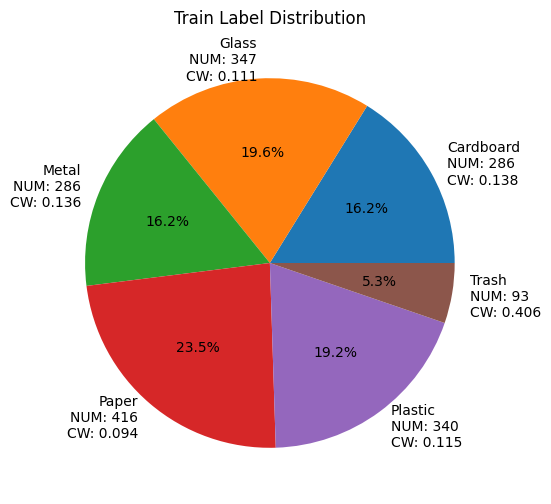

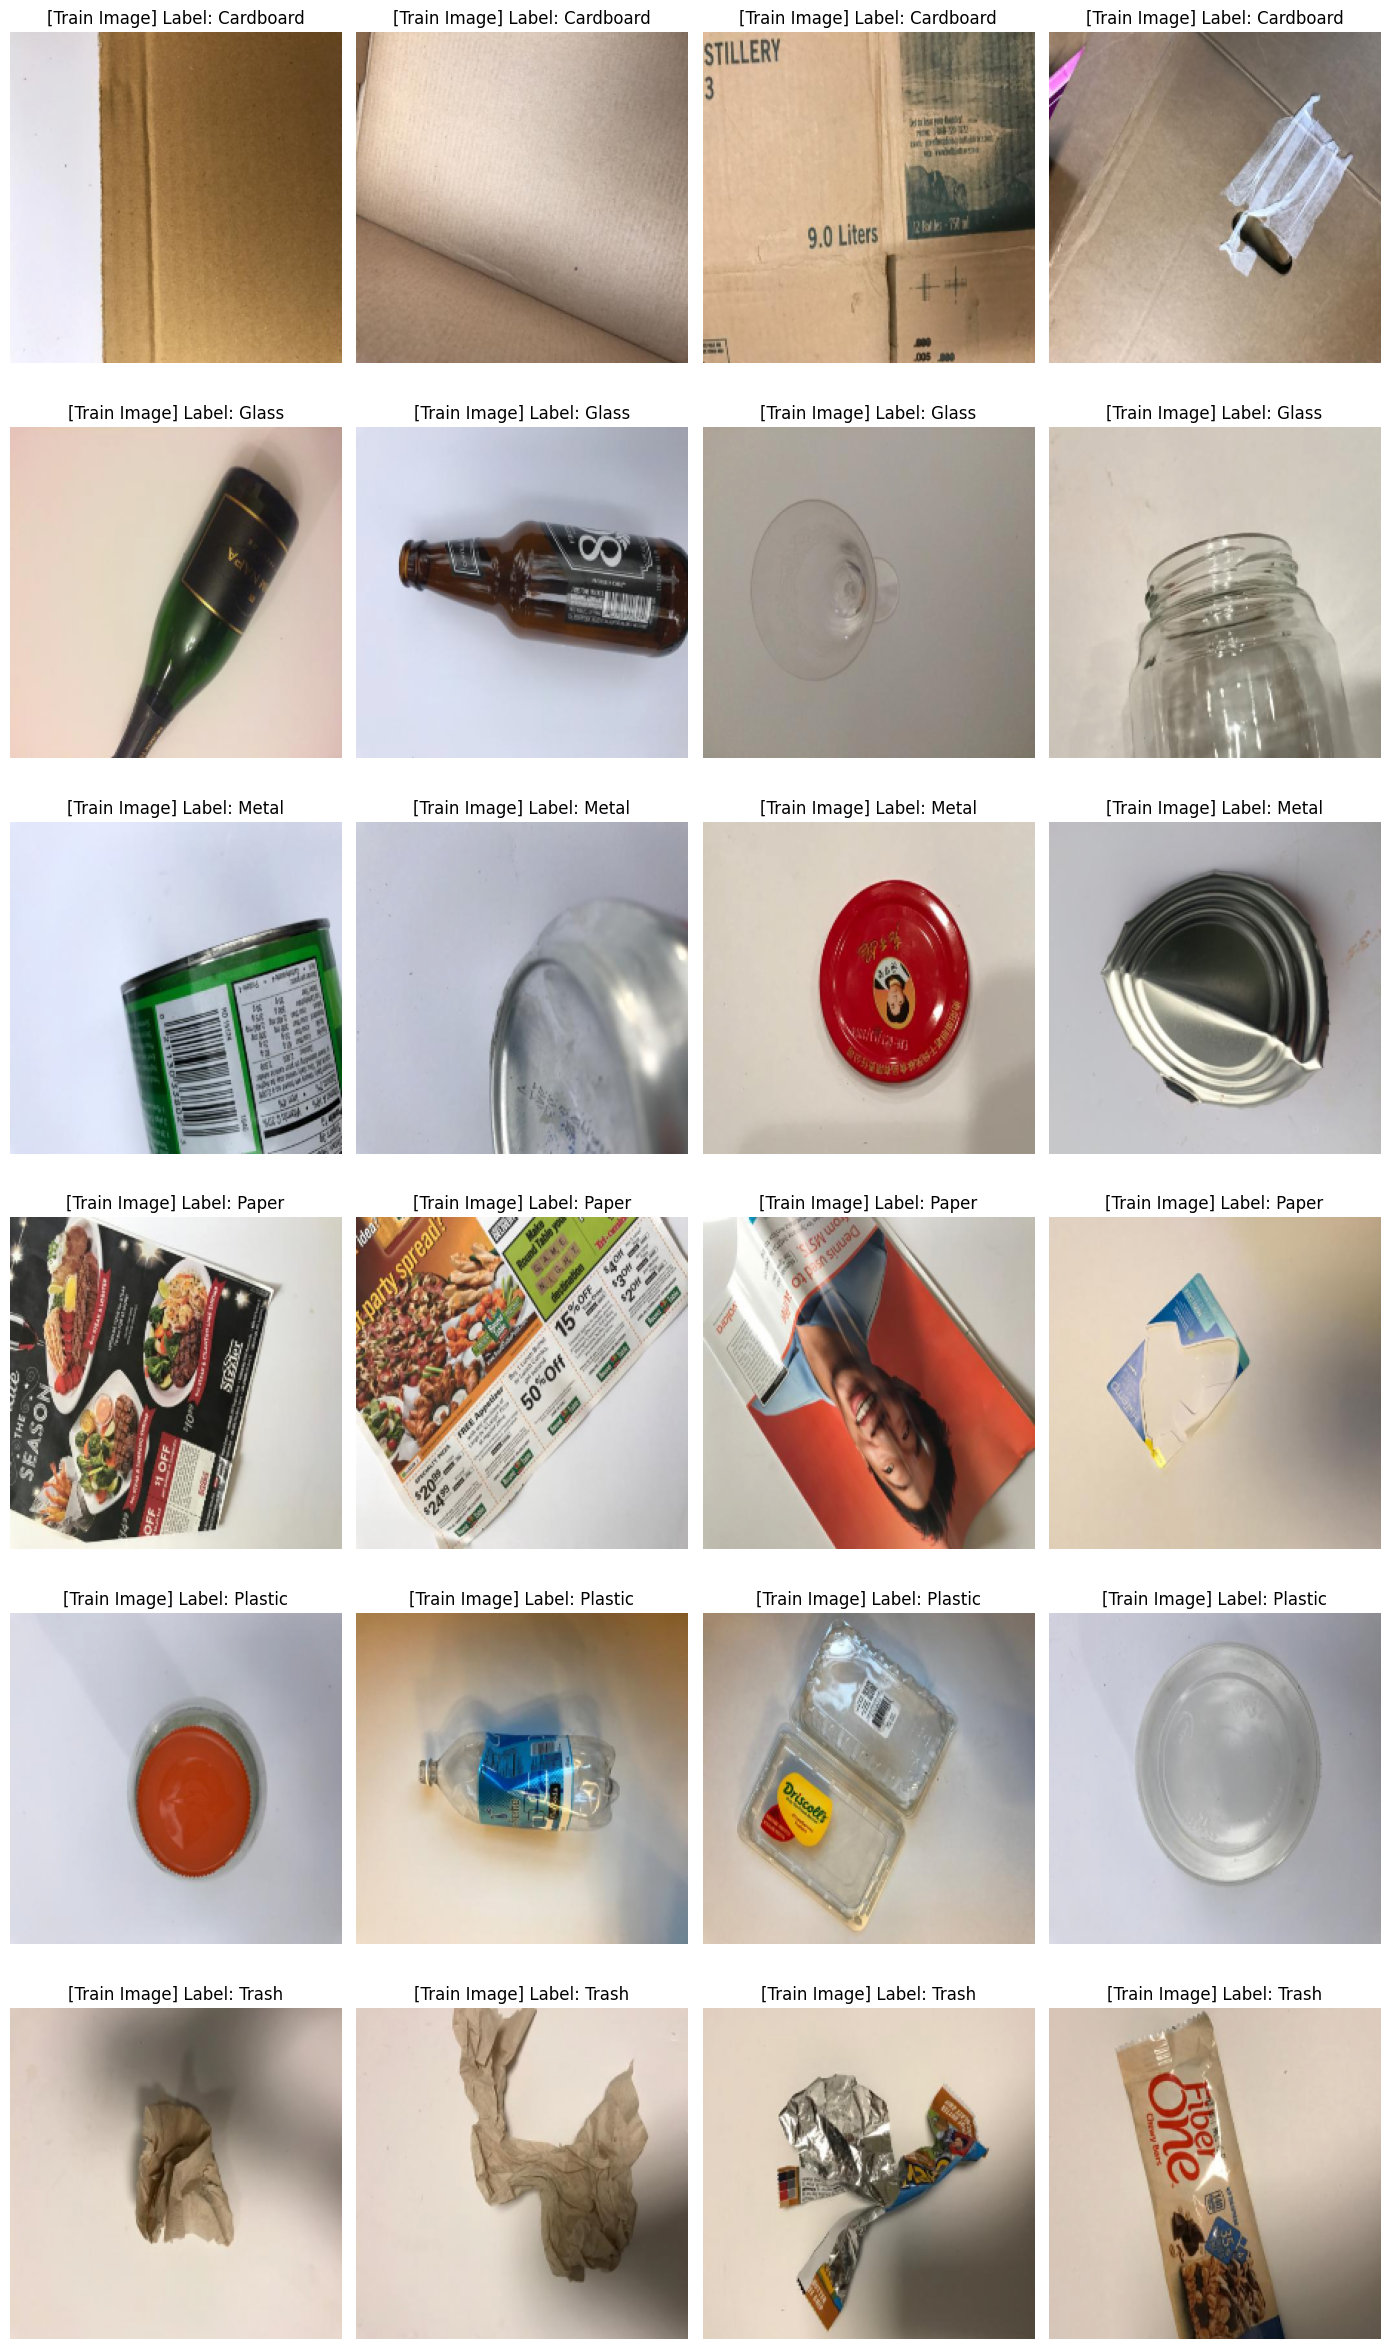

In [5]:
def plot_label_distribution(labels, labels_names, class_weights, title, subplot):
    # Convert one-hot encoded labels to class indices
    label_indices = np.argmax(labels, axis=1)

    _, counts = np.unique(label_indices, return_counts=True)

    # Convert counts to string and add to labels for pie chart
    labels_with_counts = [
        f"{label}\nNUM: {count}\nCW: {weight:.3f}"
        for label, count, weight in zip(labels_names, counts, class_weights)
    ]
    subplot.pie(counts, labels=labels_with_counts, autopct="%1.1f%%")
    subplot.set_title(title)


def plot_example_images(images, labels, labels_names, num_classes, title, subplot):
    # Convert one-hot encoded labels to class indices
    label_indices = np.argmax(labels, axis=1)

    unique_labels = np.arange(num_classes)

    for i, label in enumerate(unique_labels):
        # Get the indices of the images that have the current label
        indices = np.where(label_indices == label)[0]
        # Select four images from the current label
        selected_images = images[indices[:4]].astype(np.float32)
        for j, image in enumerate(selected_images):
            # Plot the image
            subplot[i, j].imshow(image)
            subplot[i, j].set_title(f"[{title}] Label: {labels_names[i]}")
            subplot[i, j].axis("off")


# Create subplots for label distributions
fig, axs = plt.subplots(1, 1, figsize=(18, 6))
plot_label_distribution(y_train, labels, class_weights, "Train Label Distribution", axs)
plt.show()

# Create subplots for example images
fig, axs = plt.subplots(num_classes, 4, figsize=(14, num_classes * 4))
plot_example_images(x_train, y_train, labels, num_classes, "Train Image", axs)
plt.tight_layout()
plt.show()

## Porting for pytorch


In [6]:
# Porting for pytorch
cprint("<Fore.YELLOW>Porting for pytorch...")
Is_tensor = True
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2)
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
class_weights = torch.from_numpy(class_weights)
# End\n",
cprint("<Fore.GREEN>Done!")

Porting for pytorch...
Done!


## Models


### EfficientNet-B4

#### Best Results: (Can be improved ⚠️)
| Metric                           |     Value |
|----------------------------------|-----------|
| Loss                             | 0.0348575 |
| F1 Score (macro)                 | 0.94244   |
| Precision (macro)                | 0.940237  |
| Recall (macro)                   | 0.945437  |
| AUROC                            | 0.994676  |
| Accuracy                         | 0.949934  |
| Cohen's Kappa                    | 0.938602  |
| Matthews Correlation Coefficient | 0.938719  |

In [7]:
# Add the model info
model_info = "Efficientnet-b4: Simple FC - dropout_rate=0.11"

# Load pre-trained EfficientNet-b4
model = EfficientNet.from_pretrained(
    "efficientnet-b4",
    include_top=True,
    num_classes=num_classes,
    dropout_rate=0.11,
    in_channels=3,
)

# Prep
model = model.to(device)

# Summary
summary(model, input_size=(1, 3, 224, 224), verbose=2, depth=5, device=device_str)

Loaded pretrained weights for efficientnet-b4
Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 6]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 48, 112, 112]         1,296
│    └─weight                                                                └─1,296
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 48, 112, 112]         96
│    └─weight                                                                ├─48
│    └─bias                                                                  └─48
├─MemoryEfficientSwish: 1-3                        [1, 48, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─0._depthwise_conv.weight                                              ├─432
│    └─0._bn1.weight                                  

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 6]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 48, 112, 112]         1,296
│    └─weight                                                                └─1,296
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 48, 112, 112]         96
│    └─weight                                                                ├─48
│    └─bias                                                                  └─48
├─MemoryEfficientSwish: 1-3                        [1, 48, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─0._depthwise_conv.weight                                              ├─432
│    └─0._bn1.weight                                                         ├─48
│    └─0._bn1.bias

### EfficientNet-B6

#### Best Results:

| Metric                           |     Value |
|----------------------------------|-----------|
| Loss                             | 0.0330466 |
| F1 Score (macro)                 | 0.95472   |
| Precision (macro)                | 0.952111  |
| Recall (macro)                   | 0.957959  |
| AUROC                            | 0.993324  |
| Accuracy                         | 0.957839  |
| Cohen's Kappa                    | 0.948292  |
| Matthews Correlation Coefficient | 0.948374  |

In [14]:
# Add the model info
model_info = "Efficientnet-b6: Simple FC - dropout_rate=0.52 - drop_connect_rate=0.24"

# Load pre-trained EfficientNet-B6
model = EfficientNet.from_pretrained(
    "efficientnet-b6",
    include_top=True,
    num_classes=num_classes,
    drop_connect_rate=0.24,
    dropout_rate=0.52,
    in_channels=3,
)

# Prep
model = model.to(device)

# Summary
summary(model, input_size=(1, 3, 224, 224), verbose=2, depth=5, device=device_str)

Loaded pretrained weights for efficientnet-b6
Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 6]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 56, 112, 112]         1,512
│    └─weight                                                                └─1,512
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 56, 112, 112]         112
│    └─weight                                                                ├─56
│    └─bias                                                                  └─56
├─MemoryEfficientSwish: 1-3                        [1, 56, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─0._depthwise_conv.weight                                              ├─504
│    └─0._bn1.weight                                 

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 6]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 56, 112, 112]         1,512
│    └─weight                                                                └─1,512
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 56, 112, 112]         112
│    └─weight                                                                ├─56
│    └─bias                                                                  └─56
├─MemoryEfficientSwish: 1-3                        [1, 56, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─0._depthwise_conv.weight                                              ├─504
│    └─0._bn1.weight                                                         ├─56
│    └─0._bn1.bia

## Training System


In [8]:
# Conf Prep
try:
    [globals().pop(key) for key in Train_Confs]  # type: ignore  # noqa: F821
except Exception:
    pass
Conf_recorder = Record_var()
Conf_recorder.Start(globals())  # For capturing train configs
# fmt: off
# Conf >>> ------------------------------------------------------------------------------------------------ | (Sorry for the Experiment Parameter Hell!)
batch_size = 16  # Batch size (If you need to use a large batch size use gradient_accumulation to save memory)
max_epochs = 512  # Maximum number of epochs to train for
early_stop = True  # If True, the training will stop if the validation loss does not improve for n epochs
agmentation = True  # If True, the data will be augmented [Pre_epoch: before each epoch] - [runtime: during each epoch]
noise_injection = False  # If True, the data will be augmented with noise injection. Warning: This will add noise aside from the augmentation. & Effects the training speed.
noise_injection_std = 0.00025  # The standard deviation of the noise to be injected.
noise_injection_mean = 0.0  # The mean of the noise to be injected.
augmentation_magnitude = 2  # 1-30 for when dynamic_agmentation_scaling is off.
dynamic_agmentation_scaling = True  # if True, the magnitude will be scaled with the epoch
dynamic_agmentation_scaling_fn = lambda epoch: min(epoch / (98 / 1), 8)  # output: magnitude (1-30) | input: epoch
early_stop_patience = 86  # After n epochs without improvement, stop training and load the best model
train_eval_portion = 0.14  # The proportion of the training data that it used to messure the model's performance on train data
gradient_clipping = True  # If True, the gradient will be clipped to a maximum value/norm (Pervent exploding gradients)
gradient_clipping_max = 1.2  # The maximum of the gradient
gradient_clipping_method = "Norm"  # "Norm" or "Value"
agmentation_method = "runtime"  # "runtime" (Stable-LowRamUsage) Recomended or "Pre_epoch" (Unstable-HighRamUsage) Deparicated!
gradient_accumulation = False # If True, the gradient will be accumulated over multiple batches before being applied to the model. (To save memory if you need to use a large batch size)
gradient_accumulation_steps = 2  # The number of batches to accumulate the gradient over
exponential_moving_average = True  # If True, the model will be averaged over the last n epochs
ema_decay = 0.65 # The decay of the exponential moving average (Set a low value if you are using "Epoch" ema_length)
lr_scheduler_update_method = "Epoch"  # "Batch" or "Epoch"
ema_bn_update_freq = float("inf")  #  The frequency of updating the batch normalization statistics
ema_length = "Epoch" # "Epoch" or "Full_Training"
profile_lr_scheduler = False  # If True, the learning rate scheduler will be profiled. Warning: This can corrupt the learning rate scheduler and it will raise an error to stop the training.
ms_normalization = False  # If True, the dataset will be normalized with mean and std
mixed_precision_training = False  # If True, the training will use mixed precision training
data_loader_workers_force = None  # Force the number of workers to be this value. If None, the number of workers will be set to the number of CPU cores.
Debug_freq = {"Save_Augmentation_sample": 8, "TB_Augmentation_sample": 4}
# Conf Capture
Train_Confs = Conf_recorder.Capture(globals()) # For capturing train configs
# Optimizers ---------------------------------------------------------------------------------------------- |
# optimizer = TP_optim.DiffGrad(
#     model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4
# )
# optimizer = TP_optim.AdaBound(
#     model.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.999),
#     final_lr=0.1,
#     gamma=1e-3,
#     eps=1e-8,
#     weight_decay=0,
#     amsbound=True,
# )
# optimizer = (
#     TP_optim.PID(  # Can work better than SGD but needs tuning (integral & derivative)
#         model.parameters(),
#         lr=0.008,
#         momentum=0.9,
#         weight_decay=0.0005,
#         integral=3,
#         derivative=64,
#     )
# )
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,
#     amsgrad=True,
#     weight_decay=5e-6,
# )
optimizer = torch.optim.SGD(
    [
        {
            "params": [
                param for name, param in model.named_parameters() if "bias" not in name and "bn" not in name
            ]
        },
        {
            "params": [
                param for name, param in model.named_parameters() if "bias" in name or "bn" in name
            ],
            "weight_decay": 0,
        },
    ],
    lr=0.0104,
    weight_decay=0.0042,
    momentum=0.91,
    nesterov=True,
)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0104, weight_decay=0.001, momentum=0.94, nesterov=True)
optimizer = TP_optim.Lookahead(optimizer, k=6, alpha=0.5) # Can improve the training results.
# Conf Recorder
Conf_recorder.Start(globals()) # For capturing the lr_scheduler
# Learning rate schedulers -------------------------------------------------------------------------------- |
def Epoch_to_Steps(epoch):
    return epoch * (len(y_train) // (batch_size * gradient_accumulation_steps if gradient_accumulation else batch_size))
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     three_phase=True,
#     max_lr=0.0075,
#     epochs=84,
#     pct_start=0.15,
#     final_div_factor=50,
#     steps_per_epoch=Epoch_to_Steps(1),
# )
lr_scheduler = Lr_schedulers.CosineAnnealingLR_Warmup(  # A type of Onecycle learning rate scheduler
    optimizer,
    warmup_iters=7,
    main_iters=84,
    lr_idling_iters=21,
    decay_iters=150,
    lr_main_min=0.005,  # 0.006
    lr_final_min=0.003,  # 0.002
    warmup_start=0.06,
)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999, last_epoch=-1)
# Conf End <<< -------------------------------------------------------------------------------------------- |
# Conf Capture
Train_Confs.update(Conf_recorder.Capture(globals())) # For capturing the lr_scheduler
# fmt: on
# Prep
torch.cuda.empty_cache()
gc.collect()
cprint("<Fore.YELLOW>Starting the traning engine...")
History = {"Train": [], "Val": []}
Cache_dict = {}
if not Is_tensor:
    raise ValueError("You should port the data to pytorch tensors first!")
loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.085)
log_dir_template = datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
TB_log_dir = f"Logs\\Tensorboard\\{log_dir_template}"
if profile_lr_scheduler:
    Lr_scheduler_profile = Lr_schedulers.Profile(
        lr_scheduler,
        Epoch_to_Steps(256) if lr_scheduler_update_method == "Batch" else 256,
        save_path=f"Reports\\{log_dir_template}\\.",
    )
    if "deepcopy-fail" in Lr_scheduler_profile["flags"]:
        raise SystemExit(
            "The learning rate scheduler has been corrupted because of the profiling. (Profiler cant make a deep copy of the scheduler)"
        )
TB_Data_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Data")
TB_Train_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Train")
TB_Val_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Validation")
train_reporter = Train_Report.Reporter(save_dir=f"Reports\\{log_dir_template}")
model = model.to(device)
Test_dataloader = DataLoader(
    dataset=TensorDataset_rtIDT(
        x_test,
        y_test,
        transformer=v2_transforms.Normalize(
            mean=norm_params["mean"], std=norm_params["std"], inplace=True
        ),
    )
    if ms_normalization
    else TensorDataset_rtDTC(x_test, y_test),
    batch_size=batch_size * 2,
    shuffle=True,
    num_workers=os.cpu_count()
    if data_loader_workers_force is None
    else data_loader_workers_force,
    pin_memory_device=device_str,
    pin_memory=True,
    drop_last=False,
)
Augment_transformer = rgb_augmentation_transform(
    magnitude=dynamic_agmentation_scaling_fn(1)
    if dynamic_agmentation_scaling
    else augmentation_magnitude,
    norm_params=norm_params if ms_normalization else None,
)
Train_Confs[f"Opt_{optimizer.__class__.__name__}_Prams"] = optimizer.defaults
Train_Confs["model_info"] = {
    "model_class_name": model.__class__.__name__,
    "model_info": model_info,
}
# Mixed Precision Training
if mixed_precision_training:
    mpt_scaler = GradScaler(device=device_str)
# Exponential Moving Average
if exponential_moving_average and ema_length == "Full_Training":
    ema_model = torch.optim.swa_utils.AveragedModel(
        model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(ema_decay)
    )
# Verbose
cprint("<Fore.YELLOW>Setup verbose:")
cprint(f" │ <Fore.CYAN>Running on: <Fore.GREEN>{device}")
for key in Train_Confs:
    cprint(f" │ <Fore.CYAN>{key}: <Fore.GREEN>{Train_Confs[key]}")
cprint(f" │ <Fore.CYAN>Train Report dir: <Fore.GREEN>{f"Reports\\{log_dir_template}"}")
cprint(f" │ <Fore.CYAN>Tensorboard log dir: <Fore.GREEN>{TB_log_dir}")
cprint(" │ <Fore.CYAN>Adding tensorboard model graph...")
TB_Data_writer.add_graph(model, torch.rand(1, x_test.shape[1], 224, 224).to(device))
train_reporter.Add_Prams(Train_Confs)
# Traing start msg
cprint("<Fore.YELLOW>Starting the training...")
# Main training loop
try:
    for Epoch in range(1, max_epochs + 1):
        # Start msg + Start time
        cprint(
            f"\nEpoch: <Fore.CYAN>{Epoch}<Style.RESET_ALL>/<Fore.GREEN>{max_epochs} -->"
        )
        Epoch_start_time = time.time()
        # Data prep
        if dynamic_agmentation_scaling:
            Augment_transformer = rgb_augmentation_transform(
                magnitude=dynamic_agmentation_scaling_fn(Epoch),
                norm_params=norm_params if ms_normalization else None,
            )
        if agmentation and agmentation_method == "Pre_epoch":
            x_train_aug = augment_tensor(
                x_train,
                Augment_transformer,
                Progbar_desc=cprint(
                    " │ <Fore.GREEN>Processing images<Style.RESET_ALL>",
                    return_string=True,
                    end="",
                ),
                mode="cpu" if CPU_only else "cuda",  # cuda for complex augmentations
                batch_size=128,
                proc_count=72,
            )
        # Data Debug samples
        img_samples_idx = np.random.choice(y_train.shape[0], size=50, replace=False)
        if agmentation:
            if agmentation_method == "Pre_epoch":
                img_samples = x_train_aug[img_samples_idx]
            else:
                img_samples = torch.stack(
                    [Augment_transformer(x_train[idx]) for idx in img_samples_idx]
                )
        else:
            img_samples = x_train[img_samples_idx]
        if noise_injection:
            img_samples = Add_gaussian_noise(
                img_samples,
                (len(img_samples_idx), *x_train.size()[1:]),
                noise_injection_mean,
                noise_injection_std,
            )
        if Epoch % Debug_freq["TB_Augmentation_sample"] == 0 or Epoch == 1:
            cprint(" │ <Fore.GREEN>Adding Debug imgs to tensorboard...")
        TB_Data_writer.add_image(
            "Debug/Train_input_img",
            vutils.make_grid(img_samples.cpu()[:16], nrow=4),
            Epoch,
        )
        if Epoch % Debug_freq["Save_Augmentation_sample"] == 0 or Epoch == 1:
            cprint(" │ <Fore.GREEN>Saving Debug imgs...")
            save_samples(
                img_samples.cpu().permute(0, 2, 3, 1).numpy(),
                y_train[img_samples_idx].cpu().numpy(),
                "Debug\\Img_Samples\\Train_Aug\\",
                label_names=labels,
                jpeg_quality=95,
                verbose=False,
            )
        del img_samples_idx, img_samples
        # Data loader + sampler
        # dynamic_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        Train_dataloader = DataLoader(
            dataset=TensorDataset_rtIDT(
                x_train,
                y_train,
                transformer=Augment_transformer,
            )
            if agmentation and agmentation_method == "runtime"
            else TensorDataset_rtDTC(
                x_train_aug if agmentation else x_train,
                y_train,
            ),
            batch_size=batch_size,
            shuffle=True,
            num_workers=os.cpu_count()
            if data_loader_workers_force is None
            else data_loader_workers_force,
            pin_memory_device=device_str,
            pin_memory=True,
            drop_last=True,
        )
        # Exponential Moving Average
        if exponential_moving_average and ema_length == "Epoch":
            ema_model = torch.optim.swa_utils.AveragedModel(
                model,
                multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(ema_decay),
            )
        # Train Var Prep
        Train_total_batches = (
            int(len(Train_dataloader) / gradient_accumulation_steps)
            if gradient_accumulation
            else len(Train_dataloader)
        )
        Train_dataloader_len = len(Train_dataloader)
        TrainEval_Data_len = round(Train_total_batches * train_eval_portion)
        x_size = next(iter(Train_dataloader))[0].size()
        TrainEval_Data = []
        batch_idx = 0
        model.train()
        # Moving loss to `device`
        loss_fn = loss_fn.to(device)
        # Tarin Verbose Prep
        cprint(
            f" │ <Fore.CYAN>Train Eval History len: <Fore.GREEN>{TrainEval_Data_len}/{Train_total_batches}"
        )
        cprint(f" │ <Fore.CYAN>Lr: <Fore.GREEN>{lr_scheduler.get_last_lr()[0]:.8f}")
        TB_Data_writer.add_scalar("Learning Rate", lr_scheduler.get_last_lr()[0], Epoch)
        # Train Progbar
        progress_bar = tqdm(
            total=Train_total_batches,
            desc=cprint(
                " │ <Fore.GREEN>Training<Style.RESET_ALL>", return_string=True, end=""
            ),
            unit="batch",
        )
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
        # Train Main
        for idx, (x, y) in enumerate(Train_dataloader):
            # Optional noise injection
            if noise_injection:
                x = Add_gaussian_noise(
                    x,
                    x_size,
                    mean=noise_injection_mean,
                    std=noise_injection_std,
                )
            # Forward pass + mixed precision
            with autocast(device_type=device_str, enabled=mixed_precision_training):
                y_pred = model(x.to(device, non_blocking=True))
                loss = loss_fn(y_pred, y.to(device, non_blocking=True))
            # Normalize the loss if using gradient accumulation
            if gradient_accumulation:
                loss = loss / gradient_accumulation_steps
            # Backward pass + mixed precision
            if mixed_precision_training:
                mpt_scaler.scale(loss).backward()
            else:
                loss.backward()
            # Model param update (Train step)
            if not gradient_accumulation or (
                ((idx + 1) % gradient_accumulation_steps == 0)
                or (idx + 1 == Train_dataloader_len)
            ):
                # Update the batch_idx
                batch_idx += 1
                # Gradient clipping
                if gradient_clipping:
                    if mixed_precision_training:
                        mpt_scaler.unscale_(optimizer)
                    match gradient_clipping_method:
                        case "Norm":
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(), gradient_clipping_max
                            )
                        case "Value":
                            torch.nn.utils.clip_grad_value_(
                                model.parameters(), gradient_clipping_max
                            )
                        case _:
                            raise ValueError(
                                "gradient_clipping_method must be one of: 'Norm', 'Value'"
                            )
                # Optimizer step
                if mixed_precision_training:
                    mpt_scaler.step(optimizer)
                    mpt_scaler.update()
                else:
                    optimizer.step()
                # Zero grad
                optimizer.zero_grad()
                # Weight Averaging Param update
                ema_model.update_parameters(model)
                # Lr scheduler step
                if lr_scheduler_update_method == "Batch":
                    lr_scheduler.step()
                # Train Eval Data
                if batch_idx >= (Train_total_batches - TrainEval_Data_len):
                    progress_bar.set_postfix_str("Recording Eval Data...")
                    TrainEval_Data.append(
                        {"y_pred": y_pred.detach().cpu(), "y": y.detach().cpu()}
                    )
                # Progress bar update
                progress_bar.update()
        # Close progress bar
        progress_bar.close()
        # Lerning rate scheduler step + moving the loss to cpu + Weight Averaging bn update
        loss_fn = loss_fn.cpu()
        if lr_scheduler_update_method == "Epoch":
            lr_scheduler.step()
        if exponential_moving_average and (Epoch % ema_bn_update_freq == 0):
            cprint(" │ <Fore.GREEN>Updating BN weight averaging...")
            torch.optim.swa_utils.update_bn(Train_dataloader, ema_model, device=device)
        # Val
        Train_eval = calc_metrics(
            torch.cat([item["y"] for item in TrainEval_Data]),
            torch.cat([item["y_pred"] for item in TrainEval_Data]),
            loss_fn,
        )
        Test_eval = eval(
            Test_dataloader,
            ema_model if exponential_moving_average else model,
            device,
            loss_fn=loss_fn,
            TQDM_desc=cprint(
                f" │ <Fore.GREEN>Evaluating (Test{"-EMA" if exponential_moving_average else ""})<Style.RESET_ALL>",
                end="",
                return_string=True,
            ),
        )
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
        # Saving the results
        History["Train"].append(Train_eval)
        History["Val"].append(Test_eval)
        # Print the results
        print(
            "\n".join(
                [
                    " │ " + row
                    for row in tabulate(
                        [
                            ["Train"]
                            + [f"{Train_eval[metric]:.8f}" for metric in Train_eval],
                            ["Test"]
                            + [f"{Test_eval[metric]:.8f}" for metric in Test_eval],
                        ],
                        headers=["Set"] + list(Train_eval.keys()),
                        tablefmt="grid",
                    ).split("\n")
                ]
            )
        )
        # Tensorboard logging
        for metric in Train_eval:
            TB_Train_writer.add_scalar(f"Metrics/{metric}", Train_eval[metric], Epoch)
            TB_Val_writer.add_scalar(f"Metrics/{metric}", Test_eval[metric], Epoch)
        # Early stopping
        if EarlyStopping(
            Cache_dict,
            [Test_eval["F1 Score (macro)"], "max", "F1 Score"],
            Epoch,
            ema_model if exponential_moving_average else model,
            "Cache\\weights",
            patience=early_stop_patience,
        ):
            break
        # End (Epoch Loop)
        Epoch_time = time.time() - Epoch_start_time
        TB_Data_writer.add_scalar("Epoch Time", Epoch_time, Epoch)
        cprint(
            f"Epoch {Epoch} finished.<Fore.GREEN> ("
            + (
                f"{int(Epoch_time // 60)}m {(Epoch_time % 60):.1f}s"
                if Epoch_time >= 60
                else f"{Epoch_time:.1f}s"
            )
            + ")"
        )
except KeyboardInterrupt:
    # interrupt msg
    cprint("<Fore.YELLOW>Training interrupted.")
    # Loading the best model
    EarlyStopping_LoadBest(
        ema_model if exponential_moving_average else model,
        Cache_dict,
    )
# End (Training Engine)
if len(History["Train"]) > 6:
    train_reporter.Add_History(History)
    train_reporter.Save_Report()
else:
    cprint("<Fore.RED>Warning:<Fore.YELLOW> The training was not reported. (Too short)")
    train_reporter.Del_Report()
# TB_Data_writer.add_hparams(
#     hparam_dict={
#         f"{key}_{subkey}" if isinstance(value, dict) else key: subvalue
#         if isinstance(value, dict)
#         else value
#         for key, value in Train_Confs.items()
#         if not callable(value) and not isinstance(value, tuple)
#         for subkey, subvalue in (
#             value.items() if isinstance(value, dict) else [(key, value)]
#         )
#         if not isinstance(subvalue, tuple)
#     },
#     metric_dict={
#         "Train_abs_Acc": max([item["Accuracy"] for item in History["Train"]]),
#         "Test_abs_Acc": max([item["Accuracy"] for item in History["Val"]]),
#     },
# )
# Closing SummaryWriters
TB_Data_writer.close()
TB_Train_writer.close()
TB_Val_writer.close()
# Exponential Moving Average
if exponential_moving_average:
    if ema_length == "Full_Training":
        cprint("<Fore.GREEN>Updating BN weight averaging...")
        torch.optim.swa_utils.update_bn(Train_dataloader, ema_model, device=device)
    model.load_state_dict(
        {
            k.replace("module.", ""): v
            for k, v in ema_model.state_dict().items()
            if "module." in k
        }
    )
    del ema_model
# End
cprint("<Fore.YELLOW>Training finished.")

Starting the traning engine...
Setup verbose:
 │ Running on: cuda
 │ batch_size: 16
 │ max_epochs: 512
 │ early_stop: True
 │ agmentation: True
 │ noise_injection: False
 │ noise_injection_std: 0.00025
 │ noise_injection_mean: 0.0
 │ augmentation_magnitude: 2
 │ dynamic_agmentation_scaling: True
 │ dynamic_agmentation_scaling_fn: <function <lambda> at 0x0000020A9FCCC0E0>
 │ early_stop_patience: 86
 │ train_eval_portion: 0.14
 │ gradient_clipping: True
 │ gradient_clipping_max: 1.2
 │ gradient_clipping_method: Norm
 │ agmentation_method: runtime
 │ gradient_accumulation: False
 │ gradient_accumulation_steps: 2
 │ exponential_moving_average: True
 │ ema_decay: 0.65
 │ lr_scheduler_update_method: Epoch
 │ ema_bn_update_freq: inf
 │ ema_length: Epoch
 │ profile_lr_scheduler: False
 │ ms_normalization: False
 │ mixed_precision_training: False
 │ data_loader_workers_force: None
 │ Debug_freq: {'Save_Augmentation_sample': 8, 'TB_Augmentation_sample': 4}
 │ Epoch_to_Steps: <function Epoch_to_S

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.230198 |           0.203499 |            0.207787 |         0.220851 | 0.544482 |   0.21875  |       0.0532194 |                          0.0536846 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.24415  |           0.177307 |            0.180363 |         0.185603 | 0.516904 |   0.197628 |       0.0223313 |                          0.02256   |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.236367 |           0.260229 |            0.273612 |         0.262863 | 0.600243 |   0.28125  |        0.134245 |                           0.136524 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.237924 |           0.268117 |            0.273602 |         0.275175 | 0.638445 |   0.289855 |        0.13555  |                           0.136349 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.60batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.228779 |           0.314095 |            0.326858 |         0.340954 | 0.684361 |   0.324219 |        0.190199 |                           0.193447 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.231779 |           0.39881  |            0.418436 |         0.404466 | 0.730273 |   0.416337 |        0.294364 |                           0.297603 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.221074 |           0.431185 |            0.460179 |         0.480884 | 0.812034 |   0.441406 |        0.335668 |                           0.344577 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.223529 |           0.524476 |            0.543416 |         0.542939 | 0.814054 |   0.54282  |        0.449424 |                           0.454831 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.86batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.209126 |           0.552975 |            0.571044 |         0.585799 | 0.861909 |   0.570312 |        0.483009 |                           0.489149 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.211743 |           0.618194 |            0.636203 |         0.64716  | 0.871583 |   0.638999 |        0.565192 |                           0.571597 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.192311 |           0.634594 |            0.658618 |         0.684256 | 0.907564 |   0.652344 |        0.582764 |                           0.59357  |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.195423 |           0.655352 |            0.672109 |         0.686496 | 0.902779 |   0.678524 |        0.612632 |                           0.619079 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.174381 |           0.64679  |            0.652005 |         0.675911 | 0.894419 |   0.675781 |        0.607485 |                           0.611538 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.174904 |           0.687459 |            0.695721 |         0.718114 | 0.920964 |   0.710145 |        0.650266 |                           0.655133 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.152823 |           0.742655 |            0.74301  |         0.76247  | 0.931363 |   0.757812 |        0.707078 |                           0.709553 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.152973 |           0.712439 |            0.713413 |         0.738056 | 0.934133 |   0.736495 |        0.680895 |                           0.684042 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.81batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.126636 |           0.807537 |            0.802495 |         0.835129 | 0.957368 |   0.828125 |        0.791307 |                           0.79315  |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.137677 |           0.736332 |            0.734725 |         0.758662 | 0.942606 |   0.762846 |        0.712349 |                           0.714763 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.63batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.122379 |           0.767492 |            0.761863 |         0.804565 | 0.953735 |   0.777344 |        0.729928 |                           0.733205 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.129145 |           0.764947 |            0.76073  |         0.784031 | 0.949712 |   0.787879 |        0.741897 |                           0.743452 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.114063 |           0.810718 |            0.800679 |         0.854615 | 0.962013 |   0.824219 |        0.784994 |                           0.787727 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.122521 |           0.785451 |            0.779799 |         0.801377 | 0.954889 |   0.808959 |        0.76699  |                           0.767815 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.54batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.119411 |           0.790286 |            0.783233 |         0.802158 | 0.955909 |   0.800781 |        0.75689  |                           0.757317 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.117714 |           0.806801 |            0.802705 |         0.816259 | 0.960294 |   0.83004  |        0.792201 |                           0.792857 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.105978 |           0.815127 |            0.809193 |         0.836897 | 0.970097 |   0.824219 |        0.784504 |                           0.786036 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.113415 |           0.818804 |            0.812843 |         0.83181  | 0.963421 |   0.839262 |        0.803716 |                           0.804576 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0978513 |           0.843072 |            0.833287 |         0.88914  | 0.980732 |   0.878906 |        0.849953 |                           0.851312 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.110338  |           0.824781 |            0.816889 |         0.838917 | 0.96603  |   0.844532 |        0.810159 |                           0.810635 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.80batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.089747 |           0.862569 |            0.851287 |         0.896996 | 0.988387 |   0.894531 |        0.87085  |                           0.871846 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.108156 |           0.841598 |            0.835674 |         0.852309 | 0.967926 |   0.860343 |        0.829277 |                           0.829849 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.84batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0970299 |           0.878955 |            0.870053 |         0.89822  | 0.977802 |   0.886719 |        0.861182 |                            0.86251 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.105522  |           0.846918 |            0.839512 |         0.858118 | 0.970947 |   0.862978 |        0.832525 |                            0.83295 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.86batch/s]


 │ +-------+---------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |    Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+=========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.08809 |           0.89227  |            0.88037  |         0.913524 | 0.988259 |   0.902344 |        0.880369 |                           0.880856 |
 │ +-------+---------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.10393 |           0.848634 |            0.839379 |         0.865547 | 0.971843 |   0.864295 |        0.834406 |                           0.835141 |
 │ +-------+----

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0851692 |           0.906193 |            0.898163 |         0.921173 | 0.991708 |   0.910156 |        0.890112 |                           0.890983 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.102911  |           0.862385 |            0.856161 |         0.87169  | 0.973971 |   0.87747  |        0.850211 |                           0.850766 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0809617 |           0.952394 |            0.949242 |         0.956445 | 0.993832 |   0.957031 |        0.947631 |                           0.947808 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.101961  |           0.870297 |            0.865628 |         0.87678  | 0.975472 |   0.884058 |        0.858097 |                           0.858433 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.64batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0809092 |           0.92875  |            0.91503  |         0.948245 | 0.99336  |   0.933594 |        0.9183   |                           0.919005 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.100576  |           0.874905 |            0.867937 |         0.884544 | 0.976521 |   0.88274  |        0.856609 |                           0.857047 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.60batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.082981  |           0.923064 |            0.911781 |         0.939168 | 0.994332 |   0.929688 |        0.912724 |                           0.913075 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0983562 |           0.873457 |            0.864714 |         0.886628 | 0.97755  |   0.885375 |        0.859966 |                           0.860514 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0805546 |           0.940549 |            0.926886 |         0.959935 | 0.995928 |   0.953125 |        0.941859 |                           0.94215  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0982515 |           0.880357 |            0.872195 |         0.892297 | 0.978114 |   0.891963 |        0.867951 |                           0.868416 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0760719 |           0.96451  |            0.960064 |         0.969653 | 0.996768 |   0.964844 |        0.956995 |                           0.957085 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0978039 |           0.868216 |            0.858396 |         0.886492 | 0.977018 |   0.884058 |        0.858598 |                           0.85952  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0802732 |           0.943892 |            0.940972 |         0.949074 | 0.995496 |   0.945312 |        0.933088 |                           0.933367 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0964363 |           0.880654 |            0.871468 |         0.894973 | 0.977816 |   0.894598 |        0.871253 |                           0.871784 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0741862 |           0.979014 |            0.974106 |         0.984728 | 0.997013 |   0.980469 |        0.976015 |                           0.976163 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0959036 |           0.886776 |            0.880063 |         0.896315 | 0.978724 |   0.898551 |        0.875949 |                           0.876446 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.077627  |           0.949317 |            0.945654 |          0.95452 | 0.995449 |   0.949219 |        0.937301 |                           0.937601 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0955832 |           0.880221 |            0.870642 |          0.89577 | 0.978978 |   0.895916 |        0.872907 |                           0.873443 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0764734 |           0.963306 |            0.957697 |         0.970034 | 0.995312 |   0.964844 |        0.957139 |                           0.957211 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0957513 |           0.887927 |            0.883802 |         0.893662 | 0.978667 |   0.899868 |        0.877423 |                           0.877761 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0743861 |           0.963696 |            0.955093 |         0.975026 | 0.997422 |   0.96875  |        0.961589 |                           0.961825 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0958334 |           0.898624 |            0.893964 |         0.904419 | 0.979426 |   0.906456 |        0.885466 |                           0.885682 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.43batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0753072 |           0.971172 |            0.964597 |         0.979306 | 0.998111 |   0.972656 |        0.966326 |                           0.966655 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0955915 |           0.905261 |            0.905434 |         0.906322 | 0.979774 |   0.911726 |        0.891793 |                           0.892082 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0721553 |           0.976931 |            0.977682 |         0.976711 | 0.998128 |   0.972656 |        0.966356 |                           0.966502 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0926449 |           0.902298 |            0.896945 |         0.909161 | 0.981488 |   0.911726 |        0.891941 |                           0.892199 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.51batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0713383 |           0.981131 |            0.977025 |         0.986501 | 0.998847 |   0.984375 |        0.980862 |                           0.981009 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0922489 |           0.90408  |            0.896207 |         0.915601 | 0.981933 |   0.915679 |        0.89689  |                           0.897302 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.45batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0716203 |           0.978895 |            0.976912 |         0.98123  | 0.999245 |   0.980469 |        0.975714 |                           0.975771 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0918529 |           0.907457 |            0.901839 |         0.914797 | 0.982844 |   0.915679 |        0.896767 |                           0.897013 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0721849 |           0.970579 |            0.965842 |         0.976046 | 0.99831  |   0.972656 |        0.966039 |                           0.966076 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.093382  |           0.90091  |            0.900478 |         0.90273  | 0.982557 |   0.913043 |        0.893444 |                           0.89376  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.45batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0734446 |           0.974142 |            0.970318 |         0.978922 | 0.99816  |   0.976562 |        0.971485 |                           0.971576 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0918425 |           0.9106   |            0.905817 |         0.916645 | 0.982885 |   0.918314 |        0.899956 |                           0.900145 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.65batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0710037 |           0.958708 |            0.94993  |         0.969729 | 0.998467 |   0.964844 |        0.956713 |                           0.956786 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0924067 |           0.907967 |            0.910562 |         0.9072   | 0.982526 |   0.915679 |        0.896601 |                           0.896954 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0710814 |           0.985371 |            0.984133 |         0.986789 | 0.999092 |   0.984375 |        0.980543 |                           0.980581 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.091176  |           0.910238 |            0.907052 |         0.914426 | 0.983564 |   0.915679 |        0.8967   |                           0.896922 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0690553 |           0.97749  |            0.971186 |         0.985186 | 0.999461 |   0.980469 |        0.97608  |                           0.976246 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.09202   |           0.914808 |            0.911688 |         0.919687 | 0.982648 |   0.920949 |        0.903192 |                           0.903583 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.66batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0739183 |           0.978684 |            0.980326 |         0.977661 | 0.997263 |   0.976562 |        0.971365 |                           0.971474 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0928076 |           0.90319  |            0.895419 |         0.914601 | 0.982062 |   0.913043 |        0.893637 |                           0.89402  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.75batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0708265 |           0.975497 |            0.975391 |         0.975828 | 0.998183 |   0.972656 |        0.966558 |                           0.966612 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0899971 |           0.916232 |            0.911087 |         0.922726 | 0.983555 |   0.924901 |        0.908047 |                           0.908263 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.59batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.069368  |           0.976535 |            0.977376 |         0.976202 | 0.999407 |   0.984375 |        0.980863 |                           0.980991 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0908259 |           0.919991 |            0.915376 |         0.926096 | 0.984016 |   0.928854 |        0.912859 |                           0.913099 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0692486 |           0.975129 |            0.9679   |         0.98535  | 0.999038 |   0.984375 |        0.980805 |                           0.980916 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0918153 |           0.91104  |            0.913502 |         0.910154 | 0.984263 |   0.922266 |        0.90467  |                           0.904961 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.067169 |           0.989923 |            0.990683 |         0.989506 | 0.999627 |   0.988281 |        0.985687 |                           0.985779 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.088983 |           0.904906 |            0.906133 |         0.904352 | 0.985419 |   0.919631 |        0.901426 |                           0.901553 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.48batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0679882 |           0.985327 |            0.98172  |         0.989433 | 0.999629 |   0.988281 |        0.985663 |                           0.9857   |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0897825 |           0.912096 |            0.913293 |         0.91258  | 0.985026 |   0.924901 |        0.907943 |                           0.908305 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0713256 |           0.974053 |            0.974097 |         0.974181 | 0.998393 |   0.976562 |        0.971368 |                           0.971422 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.092228  |           0.906596 |            0.914787 |         0.900929 | 0.98556  |   0.922266 |        0.904523 |                           0.904698 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0685924 |           0.98267  |            0.975    |         0.992537 | 0.999584 |   0.988281 |        0.985596 |                           0.985766 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0903752 |           0.913746 |            0.909867 |         0.91833  | 0.98524  |   0.923584 |        0.906371 |                           0.906475 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0692568 |           0.982005 |            0.981022 |         0.983296 | 0.997701 |   0.980469 |        0.975944 |                           0.975999 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0887881 |           0.91583  |            0.914738 |         0.917672 | 0.987353 |   0.923584 |        0.906289 |                           0.906451 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0659342 |           0.992269 |            0.992254 |         0.992465 | 0.999465 |   0.992188 |        0.990405 |                           0.990442 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0899556 |           0.916023 |            0.91789  |         0.91492  | 0.98622  |   0.926219 |        0.909484 |                           0.909637 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0658201 |           0.99254  |            0.991919 |         0.993308 | 0.999837 |   0.992188 |        0.990404 |                           0.990422 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0879633 |           0.913458 |            0.915834 |         0.912136 | 0.987068 |   0.926219 |        0.909464 |                           0.909687 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0665602 |           0.984001 |            0.978494 |         0.990566 | 0.999707 |   0.988281 |        0.985541 |                           0.985652 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0881296 |           0.911212 |            0.906305 |         0.917601 | 0.986578 |   0.922266 |        0.904788 |                           0.904982 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.44batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0670724 |           0.983101 |            0.982876 |         0.983529 | 0.999407 |   0.980469 |        0.976147 |                           0.976201 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0927477 |           0.921136 |            0.92032  |         0.923456 | 0.984006 |   0.926219 |        0.909533 |                           0.909898 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.068723  |           0.986974 |            0.985185 |         0.989072 | 0.999029 |   0.984375 |        0.980704 |                           0.98076  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0881026 |           0.920922 |            0.922347 |         0.919928 | 0.986293 |   0.926219 |        0.909449 |                           0.909542 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0649335 |           0.98864  |            0.983392 |         0.994536 | 0.999691 |   0.992188 |        0.990375 |                           0.990432 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0910813 |           0.896442 |            0.905303 |         0.891031 | 0.986341 |   0.913043 |        0.893177 |                           0.893594 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0690723 |           0.992511 |            0.991824 |         0.993367 | 0.99899  |   0.992188 |        0.990439 |                           0.990476 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0873379 |           0.916257 |            0.91833  |         0.915614 | 0.988765 |   0.926219 |        0.9095   |                           0.909812 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.67batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0648925 |           0.992972 |            0.99221  |         0.993939 | 0.999883 |   0.992188 |        0.990356 |                           0.990412 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0872926 |           0.913977 |            0.916638 |         0.912031 | 0.988291 |   0.926219 |        0.909435 |                           0.90958  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.066359  |           0.988799 |            0.98847  |         0.989204 | 0.999072 |   0.988281 |        0.985626 |                           0.985644 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0883793 |           0.906284 |            0.902797 |         0.911016 | 0.986831 |   0.920949 |        0.90314  |                           0.903335 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0639167 |           0.996296 |            0.996377 |         0.996296 | 0.999877 |   0.996094 |        0.995232 |                           0.995251 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0863146 |           0.922386 |            0.921913 |         0.923981 | 0.987432 |   0.928854 |        0.912779 |                           0.913046 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.59batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0651067 |           0.991148 |            0.991124 |         0.991223 | 0.999674 |   0.988281 |        0.985571 |                           0.98559  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0855223 |           0.915599 |            0.914121 |         0.917676 | 0.987598 |   0.928854 |        0.912778 |                           0.912911 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |   AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+=========+============+=================+====================================+
 │ | Train | 0.0662063 |           0.982075 |            0.97872  |         0.986116 | 0.99956 |   0.984375 |        0.980864 |                           0.980937 |
 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0831468 |           0.921646 |            0.918156 |         0.926362 | 0.98992 |   0.932806 |        0.917652 |                           0.917822 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.49batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0643787 |           0.989716 |            0.985615 |         0.994251 | 0.999923 |   0.992188 |        0.990314 |                           0.990352 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.082521  |           0.927156 |            0.925573 |         0.930814 | 0.990726 |   0.938076 |        0.924091 |                           0.924512 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.51batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0640826 |           1        |             1       |         1        | 0.999983 |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0835843 |           0.916986 |             0.91427 |         0.921172 | 0.990443 |   0.932806 |        0.917636 |                           0.917869 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0634381 |           0.992742 |            0.992063 |         0.993676 | 0.999918 |   0.992188 |        0.990402 |                           0.990458 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0847234 |           0.920922 |            0.918582 |         0.925867 | 0.989886 |   0.934124 |        0.919312 |                           0.919856 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0649   |           0.993154 |            0.993333 |         0.993182 | 0.999838 |   0.992188 |        0.990469 |                           0.990525 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.083774 |           0.923454 |            0.922095 |         0.928281 | 0.989672 |   0.934124 |        0.919312 |                           0.920071 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0636826 |           1        |            1        |         1        | 0.999982 |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0822609 |           0.926019 |            0.922279 |         0.932451 | 0.990112 |   0.936759 |        0.922535 |                           0.922999 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.60batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0638352 |           1        |            1        |         1        | 0.99993  |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0835775 |           0.925037 |            0.922812 |         0.930197 | 0.990288 |   0.934124 |        0.919286 |                           0.919874 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.74batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0669969 |           0.989261 |            0.993091 |         0.985913 | 0.999859 |   0.992188 |        0.99044  |                           0.990477 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0835017 |           0.918674 |            0.918243 |         0.919789 | 0.990692 |   0.927536 |        0.911075 |                           0.911222 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0651179 |           0.996463 |            0.99697  |         0.996032 | 0.999899 |   0.996094 |        0.995264 |                           0.995282 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0827756 |           0.921455 |            0.918762 |         0.926548 | 0.990602 |   0.932806 |        0.917672 |                           0.918104 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.82batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0625289 |           0.995875 |            0.995726 |         0.996124 | 1        |   0.996094 |        0.995185 |                           0.995203 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0838096 |           0.925097 |            0.925655 |         0.925228 | 0.989924 |   0.935441 |        0.920788 |                           0.920951 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0660653 |           0.98849  |            0.986895 |         0.990601 | 0.999546 |   0.988281 |        0.985426 |                           0.98552  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0823469 |           0.930862 |            0.935207 |         0.927149 | 0.990866 |   0.940711 |        0.927187 |                           0.927273 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0618452 |           1        |            1        |         1        | 0.999987 |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0857496 |           0.916942 |            0.914551 |         0.921069 | 0.9898   |   0.926219 |        0.909581 |                           0.909934 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.063812  |           0.991989 |            0.989762 |         0.994431 | 0.999959 |   0.992188 |        0.990228 |                           0.990267 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0831258 |           0.91961  |            0.922064 |         0.91752  | 0.990742 |   0.931489 |        0.915878 |                           0.915954 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.064204  |           0.992192 |            0.992063 |         0.992409 | 0.999741 |   0.992188 |        0.990468 |                           0.990487 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0800452 |           0.922668 |            0.916076 |         0.933166 | 0.99175  |   0.932806 |        0.917713 |                           0.917943 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.065187  |           0.981779 |            0.979146 |         0.985156 | 0.999574 |   0.980469 |        0.975922 |                           0.976088 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0811283 |           0.930345 |            0.928086 |         0.934896 | 0.991013 |   0.939394 |        0.925757 |                           0.926236 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0638215 |           0.996207 |            0.995833 |         0.996667 | 0.999766 |   0.996094 |        0.995239 |                           0.995258 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0820177 |           0.915146 |            0.917349 |         0.915361 | 0.99239  |   0.927536 |        0.911182 |                           0.911743 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.065091 |           0.996848 |            0.996732 |         0.997024 | 0.999984 |   0.996094 |        0.995242 |                           0.995261 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.078517 |           0.928464 |            0.923661 |         0.934697 | 0.993481 |   0.942029 |        0.928995 |                           0.92917  |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.83batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0617684 |           1        |            1        |         1        | 1        |   1        |         1       |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0804927 |           0.924384 |            0.920948 |         0.929521 | 0.992154 |   0.939394 |         0.92576 |                           0.926058 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.06378   |           0.996524 |            0.996454 |         0.996667 | 0.99988  |   0.996094 |        0.995251 |                           0.995269 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0815326 |           0.91866  |            0.914049 |         0.92608  | 0.990315 |   0.931489 |        0.916124 |                           0.916568 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.69batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0608701 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0797771 |           0.926387 |            0.924299 |         0.928869 | 0.992796 |   0.936759 |        0.922454 |                           0.922521 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0611151 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.079017  |           0.922645 |            0.919319 |         0.927116 | 0.993382 |   0.935441 |        0.920854 |                           0.920956 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0629077 |           0.996081 |            0.995726 |         0.996528 | 0.999933 |   0.996094 |        0.995199 |                           0.995218 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0797457 |           0.929793 |            0.926523 |         0.935052 | 0.992064 |   0.940711 |        0.927335 |                           0.927631 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |   AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+=========+============+=================+====================================+
 │ | Train | 0.0620704 |           1        |            1        |         1        | 1       |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Test  | 0.08074   |           0.918584 |            0.913989 |         0.926296 | 0.99176 |   0.927536 |        0.911233 |                           0.911625 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0628131 |           0.996444 |            0.995614 |         0.997355 | 0.999776 |   0.996094 |        0.995197 |                           0.995216 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0787885 |           0.938188 |            0.937814 |         0.939262 | 0.993579 |   0.944664 |        0.93215  |                           0.932309 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0618448 |           0.996666 |            0.996667 |         0.996732 | 0.999984 |   0.996094 |        0.995174 |                           0.995193 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0784372 |           0.929832 |            0.923263 |         0.939105 | 0.993059 |   0.936759 |        0.922534 |                           0.922655 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.74batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0630148 |           0.988501 |            0.987744 |         0.989496 | 0.999828 |   0.988281 |        0.985494 |                           0.98555  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0813046 |           0.921748 |            0.91515  |         0.934932 | 0.990588 |   0.935441 |        0.920986 |                           0.921403 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.63batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0622695 |           0.996904 |            0.997268 |         0.996599 | 1        |   0.996094 |        0.99518  |                           0.995198 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0806277 |           0.929662 |            0.926564 |         0.933609 | 0.991385 |   0.936759 |        0.922457 |                           0.922534 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610669 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0796596 |           0.926822 |            0.925715 |         0.928611 | 0.992578 |   0.934124 |        0.919194 |                           0.919309 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0620631 |           0.993012 |            0.992521 |         0.99359  | 0.999953 |   0.992188 |        0.990455 |                           0.990473 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0804668 |           0.915646 |            0.911624 |         0.920624 | 0.991826 |   0.928854 |        0.912839 |                           0.912962 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.061089  |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0783943 |           0.933685 |            0.928582 |         0.939992 | 0.993001 |   0.945982 |        0.933815 |                           0.933871 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.79batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.064973  |           0.993368 |            0.993924 |         0.992945 | 0.99821  |   0.992188 |        0.990333 |                           0.990371 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0795776 |           0.923154 |            0.917272 |         0.933481 | 0.992385 |   0.932806 |        0.917727 |                           0.918155 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610459 |           0.996831 |            0.997512 |         0.996212 | 0.999982 |   0.996094 |        0.995163 |                           0.995181 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0792466 |           0.919573 |            0.918583 |         0.92235  | 0.993865 |   0.932806 |        0.917586 |                           0.917934 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.60batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0604506 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0819147 |           0.924969 |            0.926955 |         0.924702 | 0.992939 |   0.936759 |        0.922422 |                           0.922833 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0622582 |           0.989543 |            0.985417 |         0.994111 | 0.999921 |   0.992188 |        0.990326 |                           0.990364 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0810717 |           0.922054 |            0.919625 |         0.926101 | 0.992428 |   0.936759 |        0.922472 |                           0.922747 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.54batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0645077 |           0.991294 |            0.991228 |         0.991803 | 0.999572 |   0.988281 |        0.985481 |                           0.985649 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0789315 |           0.929869 |            0.925632 |         0.935583 | 0.993428 |   0.940711 |        0.927355 |                           0.927528 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0616129 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0791619 |           0.920663 |            0.915301 |         0.927538 | 0.993549 |   0.934124 |        0.919321 |                           0.919456 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0632665 |           0.992666 |            0.992666 |         0.992666 | 0.99979  |   0.992188 |        0.990427 |                           0.990427 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0805186 |           0.909666 |            0.901755 |         0.922789 | 0.992838 |   0.927536 |        0.911428 |                           0.911858 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.53batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0617357 |           0.99254  |            0.99187  |         0.993478 | 1        |   0.992188 |        0.990432 |                           0.990487 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0805115 |           0.908463 |            0.902675 |         0.916995 | 0.991207 |   0.923584 |        0.906507 |                           0.906899 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.79batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0604713 |            1       |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0778434 |            0.92481 |            0.918511 |         0.933966 | 0.994284 |   0.935441 |        0.920978 |                           0.921256 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.51batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0615833 |           0.99335  |            0.99263  |         0.994253 | 0.999938 |   0.992188 |        0.990203 |                           0.99026  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0797365 |           0.918775 |            0.919792 |         0.918588 | 0.993009 |   0.930171 |        0.91435  |                           0.914527 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0640023 |           0.991948 |            0.992803 |         0.9913   | 0.999985 |   0.992188 |        0.990358 |                           0.990396 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0778936 |           0.928806 |            0.923909 |         0.935965 | 0.992927 |   0.938076 |        0.924159 |                           0.924449 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0621339 |           0.992688 |            0.992905 |         0.992534 | 0.998999 |   0.992188 |        0.990279 |                           0.990297 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0786246 |           0.930346 |            0.927718 |         0.936323 | 0.993277 |   0.939394 |        0.92574  |                           0.926335 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.48batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0601602 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0786011 |           0.932516 |            0.930466 |         0.935243 | 0.993937 |   0.944664 |        0.932132 |                           0.932251 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610044 |           0.989676 |            0.987756 |         0.992063 | 0.999963 |   0.992188 |        0.99044  |                           0.990496 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0769071 |           0.930414 |            0.924316 |         0.939005 | 0.994408 |   0.942029 |        0.929008 |                           0.929197 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.88batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0626657 |           0.988966 |            0.988813 |         0.989543 | 0.999629 |   0.988281 |        0.985514 |                           0.985606 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0778067 |           0.928258 |            0.92277  |         0.936749 | 0.993287 |   0.939394 |        0.92578  |                           0.926078 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.85batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612606 |           0.996188 |            0.996528 |         0.995935 | 0.999932 |   0.996094 |        0.995213 |                           0.995232 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0759471 |           0.928235 |            0.921474 |         0.940094 | 0.994384 |   0.942029 |        0.929034 |                           0.92932  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0613996 |           0.992913 |            0.992589 |         0.993387 | 0.999986 |   0.992188 |        0.99046  |                           0.990497 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.080028  |           0.910397 |            0.903504 |         0.92416  | 0.992932 |   0.924901 |        0.908154 |                           0.908761 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0638143 |            0.99665 |            0.996454 |         0.996914 | 0.999985 |   0.996094 |        0.995186 |                           0.995205 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0757429 |            0.92571 |            0.916317 |         0.941814 | 0.994149 |   0.938076 |        0.92432  |                           0.924751 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0625997 |           0.992827 |            0.993865 |         0.991949 | 0.999396 |   0.992188 |        0.990343 |                           0.990381 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.077588  |           0.920752 |            0.914777 |         0.929181 | 0.993901 |   0.935441 |        0.92099  |                           0.921289 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612555 |           1        |            1        |         1        | 1        |   1        |        1        |                            1       |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0790451 |           0.923877 |            0.918562 |         0.931901 | 0.992848 |   0.936759 |        0.922557 |                            0.92288 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0606084 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0782995 |           0.926089 |            0.921396 |         0.932744 | 0.993138 |   0.936759 |        0.922558 |                           0.922867 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0597491 |           1        |             1       |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0779241 |           0.924814 |             0.91674 |         0.939162 | 0.992348 |   0.938076 |        0.924306 |                           0.924881 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0624208 |           0.988988 |            0.988364 |         0.989723 | 0.99983  |   0.988281 |        0.985642 |                           0.98566  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0767719 |           0.94244  |            0.940237 |         0.945437 | 0.994674 |   0.949934 |        0.938602 |                           0.938719 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0606661 |           0.996857 |            0.997175 |         0.996599 | 1        |   0.996094 |        0.995178 |                           0.995197 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0781382 |           0.929966 |            0.924281 |         0.937677 | 0.993168 |   0.942029 |        0.929029 |                           0.92929  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.74batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0606694 |           0.992925 |            0.992231 |         0.993827 | 1        |   0.992188 |        0.990355 |                           0.990411 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0785049 |           0.929303 |            0.92732  |         0.931637 | 0.992969 |   0.942029 |        0.928923 |                           0.928984 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.54batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0618477 |           0.99293  |            0.991969 |         0.994046 | 0.999863 |   0.992188 |        0.990469 |                           0.990506 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0774838 |           0.926255 |            0.918446 |         0.938863 | 0.992525 |   0.939394 |        0.925837 |                           0.926064 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.92batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612465 |           0.993339 |            0.993339 |         0.993339 | 0.999968 |   0.992188 |        0.990257 |                           0.990257 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0788733 |           0.930852 |            0.929473 |         0.93364  | 0.993019 |   0.940711 |        0.927257 |                           0.927496 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0602857 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0775757 |           0.910285 |            0.901788 |         0.923344 | 0.992864 |   0.924901 |        0.908198 |                           0.908567 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.81batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0629986 |           0.989586 |            0.989352 |         0.98988  | 0.999659 |   0.988281 |        0.985704 |                           0.985723 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0792961 |           0.923879 |            0.91688  |         0.933449 | 0.992931 |   0.938076 |        0.9242   |                           0.924346 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0619256 |           0.986951 |            0.980882 |         0.99397  | 0.999916 |   0.992188 |        0.990235 |                           0.990273 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0755824 |           0.927967 |            0.920119 |         0.940579 | 0.993762 |   0.940711 |        0.927458 |                           0.927679 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.24batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0599236 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0824577 |           0.915158 |            0.914275 |         0.919141 | 0.990817 |   0.927536 |        0.911097 |                           0.911618 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.060082  |           0.996855 |            0.996855 |         0.996914 | 0.999984 |   0.996094 |        0.995192 |                           0.99521  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0822481 |           0.902067 |            0.89721  |         0.921809 | 0.990642 |   0.920949 |        0.90346  |                           0.904555 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.51batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0605036 |           0.99678  |            0.996599 |         0.997024 | 0.999952 |   0.996094 |        0.995144 |                           0.995163 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.08053   |           0.922583 |            0.922418 |         0.923169 | 0.992639 |   0.936759 |        0.922404 |                           0.922488 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.53batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0604311 |           0.997199 |            0.997222 |         0.997222 | 0.999972 |   0.996094 |        0.995206 |                           0.995225 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.078933  |           0.919239 |            0.914564 |         0.928452 | 0.992921 |   0.930171 |        0.914492 |                           0.915061 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.061857 |           0.996626 |            0.997024 |         0.996296 | 0.99997  |   0.996094 |        0.995183 |                           0.995202 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.07833  |           0.927814 |            0.920187 |         0.938709 | 0.993286 |   0.939394 |        0.925859 |                           0.926171 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0609506 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0765885 |           0.934175 |            0.930063 |         0.939286 | 0.994824 |   0.945982 |        0.933843 |                           0.934041 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0618642 |           0.980722 |            0.975802 |         0.986865 | 0.999855 |   0.984375 |        0.980804 |                           0.980896 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.078171  |           0.935005 |            0.932191 |         0.939632 | 0.99417  |   0.942029 |        0.92899  |                           0.929356 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.63batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0605776 |           0.996598 |            0.996599 |         0.996667 | 0.999968 |   0.996094 |        0.995205 |                           0.995223 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0795884 |           0.920721 |            0.918115 |         0.925197 | 0.991088 |   0.932806 |        0.917645 |                           0.917987 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0645478 |           0.972496 |            0.968488 |         0.979167 | 0.997859 |   0.980469 |        0.975804 |                           0.976099 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0778947 |           0.925848 |            0.925548 |         0.928165 | 0.995352 |   0.938076 |        0.924114 |                           0.924582 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.67batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0615441 |           0.993372 |            0.993372 |         0.993372 | 0.999693 |   0.992188 |        0.990337 |                           0.990337 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0795427 |           0.919419 |            0.912481 |         0.931834 | 0.993839 |   0.931489 |        0.916248 |                           0.916997 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.49batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0611869 |           0.993528 |            0.993478 |         0.993703 | 0.999926 |   0.992188 |        0.990387 |                           0.990425 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0784711 |           0.912204 |            0.903544 |         0.931615 | 0.993346 |   0.927536 |        0.911497 |                           0.91214  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |   AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+=========+============+=================+====================================+
 │ | Train | 0.0599617 |           1        |            1        |         1        |  1      |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+---------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0793429 |           0.926275 |            0.923879 |         0.931518 |  0.9939 |   0.936759 |        0.922514 |                           0.923052 |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610591 |           0.996136 |            0.995833 |         0.996528 | 0.99998  |   0.996094 |        0.995219 |                           0.995238 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0791752 |           0.913647 |            0.907925 |         0.921631 | 0.993808 |   0.928854 |        0.91287  |                           0.913028 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.72batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0602255 |           0.993046 |            0.992905 |         0.99326  | 0.999983 |   0.992188 |        0.99039  |                           0.990408 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0790571 |           0.917721 |            0.909415 |         0.931736 | 0.993409 |   0.932806 |        0.917878 |                           0.918371 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.65batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0600328 |           1        |            1        |         1        | 1        |   1        |        1        |                            1       |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0787428 |           0.916396 |            0.909792 |         0.929023 | 0.993311 |   0.931489 |        0.916156 |                            0.91658 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0606954 |           0.995718 |            0.994949 |         0.996599 | 1        |   0.996094 |        0.995181 |                           0.995199 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0820856 |           0.908025 |            0.900781 |         0.924438 | 0.990671 |   0.923584 |        0.906593 |                           0.907125 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.61batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0600099 |           1        |             1       |         1        | 0.999986 |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0770127 |           0.930061 |             0.92398 |         0.938959 | 0.993546 |   0.943347 |        0.930681 |                           0.931069 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.64batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0601253 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0783245 |           0.926398 |            0.919978 |         0.935432 | 0.993083 |   0.936759 |        0.922602 |                           0.922946 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.060964  |           0.993805 |            0.994406 |         0.993266 | 0.999956 |   0.992188 |        0.990334 |                           0.990353 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0786585 |           0.923421 |            0.91574  |         0.938311 | 0.993566 |   0.934124 |        0.919453 |                           0.920234 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.060532  |           0.992846 |            0.992142 |         0.993709 | 0.999932 |   0.992188 |        0.990326 |                           0.990364 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0798415 |           0.91527  |            0.906389 |         0.931725 | 0.988013 |   0.930171 |        0.914675 |                           0.915114 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612659 |           0.989525 |            0.990392 |         0.988947 | 0.999954 |   0.988281 |        0.985592 |                           0.985666 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0805198 |           0.919002 |            0.910829 |         0.931946 | 0.99081  |   0.935441 |        0.92107  |                           0.92138  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0613848 |           0.984765 |            0.985334 |         0.98446  | 0.999935 |   0.984375 |        0.980847 |                           0.98092  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0809166 |           0.930041 |            0.928682 |         0.931874 | 0.99118  |   0.943347 |        0.930522 |                           0.930607 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.69batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0605564 |           1        |            1        |         1        | 0.999969 |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0797592 |           0.913726 |            0.905185 |         0.929048 | 0.991118 |   0.927536 |        0.911405 |                           0.911758 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0619167 |           0.989522 |            0.990189 |         0.988949 | 0.999787 |   0.988281 |        0.985549 |                           0.985567 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0777461 |           0.926757 |            0.921699 |         0.933313 | 0.994449 |   0.936759 |        0.922572 |                           0.922829 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.49batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0613625 |           0.992602 |            0.992063 |         0.993464 | 0.999937 |   0.992188 |        0.990443 |                           0.990517 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0777979 |           0.917825 |            0.911164 |         0.927934 | 0.992898 |   0.930171 |        0.914587 |                           0.915058 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.42batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0596309 |           0.996366 |            0.996599 |         0.996212 | 0.999982 |   0.996094 |        0.995205 |                           0.995223 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.084628  |           0.894632 |            0.888182 |         0.921372 | 0.987075 |   0.913043 |        0.894065 |                           0.895492 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610319 |           0.993139 |            0.99162  |         0.994807 | 1        |   0.992188 |        0.99022  |                           0.990259 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0798802 |           0.923974 |            0.919592 |         0.929983 | 0.991615 |   0.932806 |        0.917636 |                           0.917803 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.43batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0607005 |           0.996941 |            0.996914 |         0.997024 | 1        |   0.996094 |        0.995224 |                           0.995243 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0813477 |           0.916224 |            0.911764 |         0.922993 | 0.991837 |   0.927536 |        0.911186 |                           0.911434 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.59batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0611727 |           0.988981 |            0.987852 |         0.990494 | 0.999962 |   0.988281 |        0.985593 |                           0.985686 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0840747 |           0.895002 |            0.890697 |         0.903969 | 0.990345 |   0.913043 |        0.893568 |                           0.894246 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0594794 |           1        |            1        |         1        | 1        |   1        |        1        |                           1        |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0819274 |           0.916147 |            0.908375 |         0.929884 | 0.990115 |   0.931489 |        0.916216 |                           0.916657 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0601519 |           0.995644 |            0.994949 |         0.996454 | 0.999977 |   0.996094 |        0.995203 |                           0.995222 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0798089 |           0.922795 |            0.91769  |         0.933311 | 0.991507 |   0.935441 |        0.920983 |                           0.92168  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.28batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0624519 |           0.986126 |            0.985951 |         0.986372 | 0.999833 |   0.984375 |        0.980862 |                           0.98088  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0839696 |           0.912458 |            0.909089 |         0.92093  | 0.991549 |   0.923584 |        0.906344 |                           0.907046 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.06262   |           0.99665  |            0.997436 |         0.995935 | 0.995948 |   0.996094 |        0.995177 |                           0.995196 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0811484 |           0.929021 |            0.926531 |         0.932721 | 0.991761 |   0.938076 |        0.924093 |                           0.924304 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.65batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0595668 |           0.996744 |            0.997024 |         0.996528 | 1        |   0.996094 |        0.995152 |                           0.995171 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0916538 |           0.891645 |            0.905181 |         0.882435 | 0.989127 |   0.907773 |        0.886434 |                           0.887531 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0601798 |           0.996628 |            0.995614 |         0.997717 | 1        |   0.996094 |        0.995126 |                           0.995145 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0865313 |           0.893459 |            0.891832 |         0.900932 | 0.991856 |   0.909091 |        0.888731 |                           0.889845 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.37batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0607648 |           0.98971  |            0.989428 |         0.990152 | 0.99997  |   0.988281 |        0.985624 |                           0.985661 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0855417 |           0.903301 |            0.904807 |         0.905814 | 0.992409 |   0.911726 |        0.891809 |                           0.89277  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.60batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0606348 |           0.98498  |            0.98125  |         0.989384 | 1        |   0.988281 |        0.985502 |                           0.985577 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.085345  |           0.892035 |            0.884423 |         0.90727  | 0.991312 |   0.907773 |        0.887309 |                           0.888015 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0609783 |           0.996939 |            0.996667 |         0.997268 | 0.999967 |   0.996094 |        0.995201 |                            0.99522 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0887104 |           0.886115 |            0.880978 |         0.900797 | 0.986424 |   0.903821 |        0.882389 |                            0.88326 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.41batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.061634  |           0.989051 |            0.986806 |         0.991758 | 0.999981 |   0.992188 |        0.990419 |                           0.990456 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0945465 |           0.846648 |            0.85179  |         0.883563 | 0.983612 |   0.86693  |        0.838982 |                           0.843188 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.55batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0601833 |           0.993393 |            0.993148 |         0.993827 | 0.999966 |   0.992188 |        0.990429 |                           0.990484 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0906172 |           0.881879 |            0.875941 |         0.904514 | 0.982692 |   0.902503 |        0.881145 |                           0.882344 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.060334  |           0.993694 |            0.993937 |         0.993512 | 0.999969 |   0.992188 |        0.990433 |                           0.990452 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0858294 |           0.906734 |            0.905399 |         0.91053  | 0.985582 |   0.918314 |        0.899995 |                           0.900599 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.40batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0602914 |           0.992666 |            0.993331 |         0.992102 | 0.999984 |   0.992188 |        0.99045  |                           0.990468 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0909815 |           0.89947  |            0.905762 |         0.896467 | 0.987586 |   0.911726 |        0.891573 |                           0.892357 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.45batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0599683 |           0.993002 |            0.993121 |         0.992963 | 0.999984 |   0.992188 |        0.990394 |                           0.990413 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0955344 |           0.875027 |            0.872128 |         0.882364 | 0.978598 |   0.893281 |        0.869297 |                           0.870009 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612832 |           0.988774 |            0.984149 |         0.994048 | 0.99988  |   0.992188 |        0.990356 |                           0.990413 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0848339 |           0.914595 |            0.910793 |         0.920868 | 0.989508 |   0.924901 |        0.907973 |                           0.908335 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0599833 |           0.993157 |            0.992063 |         0.994536 | 1        |   0.992188 |        0.990309 |                           0.990385 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.102832  |           0.832557 |            0.846795 |         0.867103 | 0.977536 |   0.852437 |        0.821632 |                           0.82707  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.64batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.062994  |           0.986022 |            0.989574 |         0.983098 | 0.999921 |   0.988281 |        0.985668 |                           0.98576  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0937471 |           0.869953 |            0.878664 |         0.867503 | 0.986679 |   0.890646 |        0.865588 |                           0.867047 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.61batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0640016 |           0.971966 |            0.971715 |         0.972346 | 0.99968  |   0.976562 |        0.971236 |                           0.971272 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.086036  |           0.910049 |            0.912053 |         0.908851 | 0.985698 |   0.926219 |        0.909465 |                           0.90962  |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.54batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0608649 |           0.99649  |            0.996454 |         0.996599 | 0.999589 |   0.996094 |        0.995203 |                           0.995222 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0936862 |           0.867062 |            0.865707 |         0.89083  | 0.982748 |   0.889328 |        0.865214 |                           0.867131 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.65batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0615387 |           0.981095 |            0.971308 |         0.992537 | 0.999919 |   0.988281 |        0.985368 |                           0.985482 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0907325 |           0.890487 |            0.891262 |         0.896154 | 0.9825   |   0.902503 |        0.880372 |                           0.881435 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0593655 |           0.99678  |            0.997024 |         0.996599 | 1        |   0.996094 |        0.995189 |                           0.995208 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0847432 |           0.913456 |            0.912995 |         0.91592  | 0.987163 |   0.923584 |        0.906222 |                           0.906601 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.63batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.061144 |           0.986416 |            0.985953 |         0.986951 | 0.999937 |   0.984375 |        0.980568 |                           0.980587 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.083017 |           0.919947 |            0.919503 |         0.92133  | 0.983665 |   0.928854 |        0.912775 |                           0.91299  |
 │ +------

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0619627 |           0.985141 |            0.979943 |         0.991066 | 0.999881 |   0.988281 |        0.985604 |                           0.985678 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0887606 |           0.900692 |            0.90214  |         0.90074  | 0.986577 |   0.911726 |        0.891597 |                           0.892043 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0616621 |           0.984682 |            0.99326  |         0.977315 | 0.999925 |   0.992188 |        0.990335 |                           0.990373 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0964769 |           0.877445 |            0.898461 |         0.863962 | 0.982382 |   0.894598 |        0.869985 |                           0.871612 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.50batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0622334 |           0.993424 |            0.994048 |         0.993056 | 0.9999   |   0.992188 |        0.990418 |                           0.990492 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0846255 |           0.901375 |            0.899483 |         0.906774 | 0.990936 |   0.911726 |        0.891896 |                           0.892682 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.59batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.060325  |           0.996434 |            0.996914 |         0.996032 | 0.999923 |   0.996094 |        0.995214 |                           0.995233 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0880102 |           0.908013 |            0.90376  |         0.913675 | 0.986219 |   0.916996 |        0.898358 |                           0.898634 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.44batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0616331 |           0.996188 |            0.996528 |         0.995935 | 0.997493 |   0.996094 |        0.995164 |                           0.995183 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.100693  |           0.868255 |            0.876061 |         0.866001 | 0.976467 |   0.885375 |        0.859275 |                           0.860541 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0612225 |           0.996679 |            0.996454 |         0.99697  | 0.999618 |   0.996094 |        0.995196 |                           0.995214 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.102496  |           0.833213 |            0.843395 |         0.871089 | 0.981792 |   0.853755 |        0.822824 |                           0.827641 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.61batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0642314 |           0.979679 |            0.978564 |         0.981157 | 0.996437 |   0.976562 |        0.971197 |                           0.971288 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.105956  |           0.821267 |            0.846226 |         0.860075 | 0.978615 |   0.841897 |        0.809407 |                           0.817341 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.56batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0608981 |           0.987693 |            0.991582 |         0.984447 | 0.999954 |   0.992188 |        0.990356 |                           0.990393 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.105408  |           0.840301 |            0.847486 |         0.866071 | 0.976924 |   0.864295 |        0.834907 |                           0.837844 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.36batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0609409 |           0.988753 |            0.988616 |         0.98896  | 0.99993  |   0.988281 |        0.985436 |                           0.985455 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0963919 |           0.872489 |            0.874279 |         0.878765 | 0.980206 |   0.881423 |        0.854478 |                           0.855861 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.39batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0607904 |           0.996361 |            0.997076 |         0.995726 | 0.999948 |   0.996094 |        0.99522  |                           0.995239 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0975571 |           0.865461 |            0.870571 |         0.863903 | 0.979157 |   0.893281 |        0.868962 |                           0.869803 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.59batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0627597 |           0.98666  |            0.989139 |         0.98451  | 0.999401 |   0.988281 |        0.985662 |                           0.985681 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.102321  |           0.852938 |            0.851564 |         0.865633 | 0.975621 |   0.8722   |        0.843585 |                           0.844627 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0626054 |           0.98959  |            0.990582 |         0.988755 | 0.999701 |   0.988281 |        0.985546 |                           0.985583 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0918177 |           0.889078 |            0.891286 |         0.889762 | 0.9867   |   0.897233 |        0.873783 |                           0.874498 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.53batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0668193 |           0.984582 |            0.992098 |         0.977879 | 0.991883 |   0.988281 |        0.985441 |                           0.985517 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.102771  |           0.856333 |            0.861526 |         0.862827 | 0.979643 |   0.86693  |        0.836576 |                           0.839079 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.57batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0602321 |           0.991663 |            0.990991 |         0.992667 | 0.999962 |   0.992188 |        0.990331 |                           0.990387 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0921221 |           0.882779 |            0.879846 |         0.888329 | 0.986222 |   0.897233 |        0.873969 |                           0.874248 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.45batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0610442 |           0.989241 |            0.988952 |         0.989929 | 0.999921 |   0.988281 |        0.985659 |                           0.985751 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0860941 |           0.893487 |            0.883253 |         0.922649 | 0.989433 |   0.907773 |        0.887743 |                           0.889343 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:07<00:00,  3.41batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0618556 |           0.989666 |            0.990086 |         0.989599 | 0.999744 |   0.988281 |        0.985598 |                           0.98569  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0827965 |           0.907914 |            0.903119 |         0.91613  | 0.985499 |   0.916996 |        0.898343 |                           0.898781 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0609232 |           0.996626 |            0.997024 |         0.996296 | 0.999982 |   0.996094 |        0.995168 |                           0.995187 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.101731  |           0.853156 |            0.856777 |         0.864642 | 0.977502 |   0.874835 |        0.846719 |                           0.848487 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.62batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0639466 |           0.982057 |            0.982763 |         0.981694 | 0.997525 |   0.980469 |        0.976058 |                           0.976131 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.110535  |           0.807283 |            0.822339 |         0.847073 | 0.970034 |   0.828722 |        0.792759 |                           0.798975 |
 │ +

 │ Evaluating (Test-EMA): 100%|██████████| 24/24 [00:06<00:00,  3.44batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0600762 |           0.993043 |            0.992521 |          0.99365 | 0.999964 |   0.992188 |        0.990372 |                           0.99039  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.116607  |           0.803014 |            0.823787 |          0.80183 | 0.973524 |   0.832675 |        0.795103 |                           0.799934 |
 │ +

## Save model


In [16]:
# Start
cprint("<Fore.YELLOW>Saving model...")
torch.save(model, "model.pth")
# End
cprint("<Fore.GREEN>Model saved!")

Saving model...
Model saved!


## Loading model


In [7]:
# Start
cprint("<Fore.YELLOW>Loading model...")
if "model" in globals():
    cprint(
        "<Fore.RED>Warning:<Fore.YELLOW> A model is already loaded! Do you want to overwrite it? (y/n)"
    )
    if input("Do you want to overwrite it? (y/n)").lower() != "y":
        raise Exception("Model is not overwritten!")
    cprint("<Fore.YELLOW>Model is being overwritten!")
model = torch.load("model.pth")
# End
cprint("<Fore.GREEN>Model Loaded!")

Loading model...
Model Loaded!


## Analyse model Predicting performance


Analyzing model Predicting performance...


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.14batch/s]

| Metric                           |     Value |
|----------------------------------|-----------|
| Loss                             | 0.0348575 |
| F1 Score (macro)                 | 0.94244   |
| Precision (macro)                | 0.940237  |
| Recall (macro)                   | 0.945437  |
| AUROC                            | 0.994676  |
| Accuracy                         | 0.949934  |
| Cohen's Kappa                    | 0.938602  |
| Matthews Correlation Coefficient | 0.938719  |


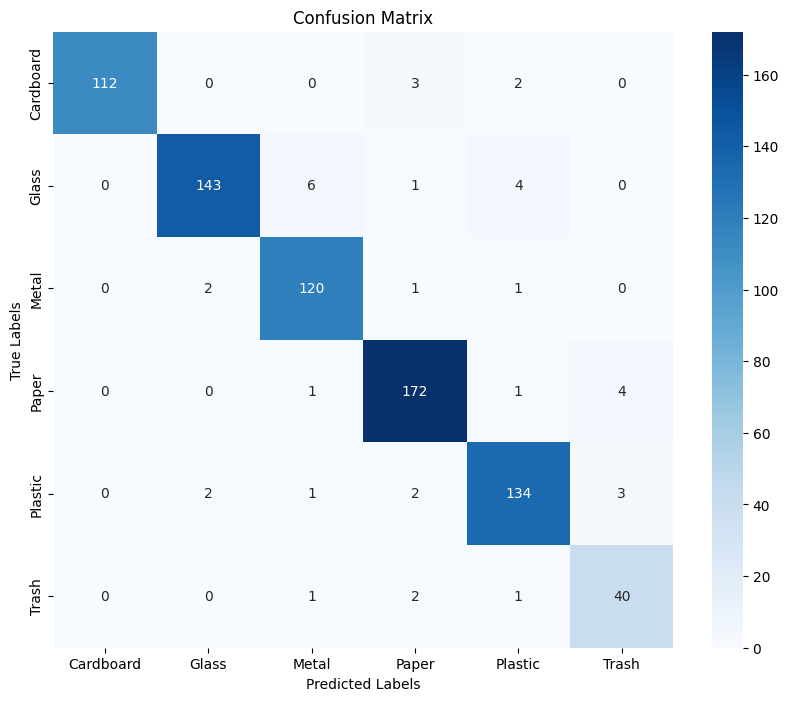

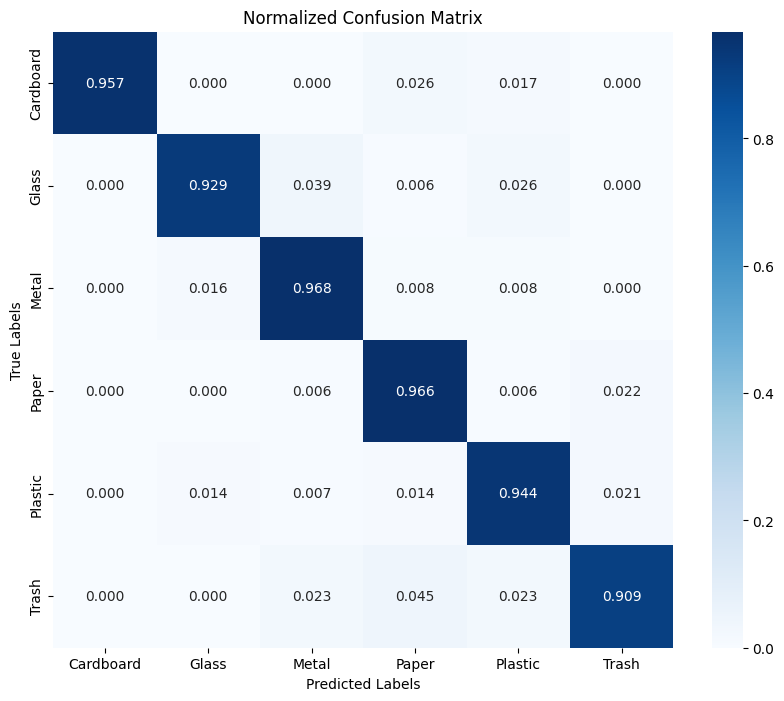

Making model activation map:   0%|          | 0/6 [00:00<?, ?it/s]

 │ Processing images: 5it [00:00, 12.12it/s]


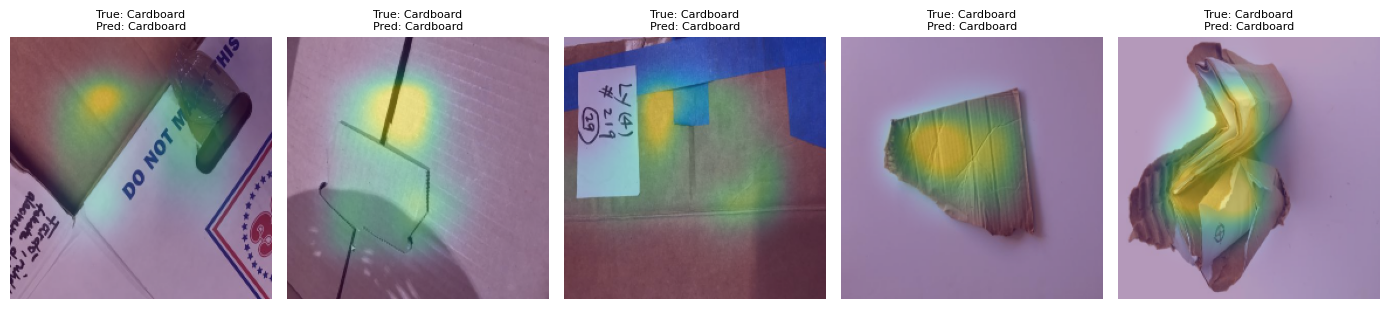

Making model activation map:  17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 │ Processing images: 5it [00:00, 19.21it/s]


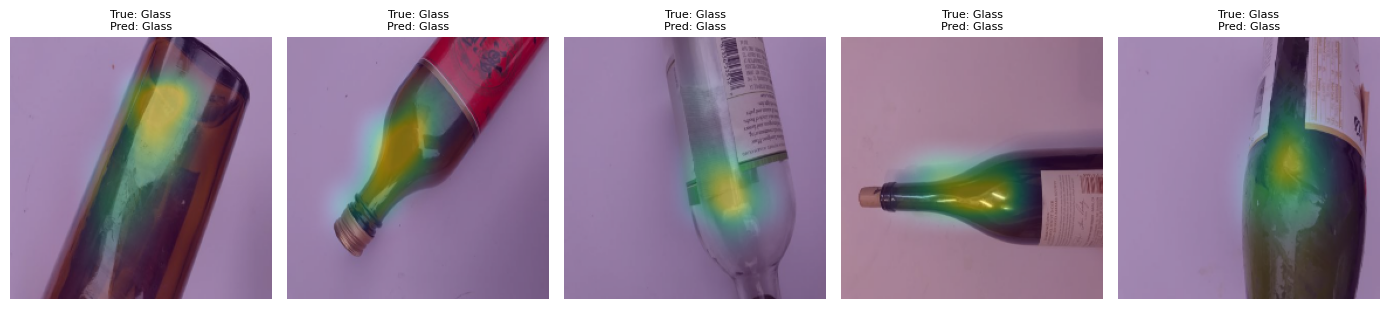

Making model activation map:  33%|███▎      | 2/6 [00:01<00:02,  1.94it/s]

 │ Processing images: 5it [00:00, 15.63it/s]


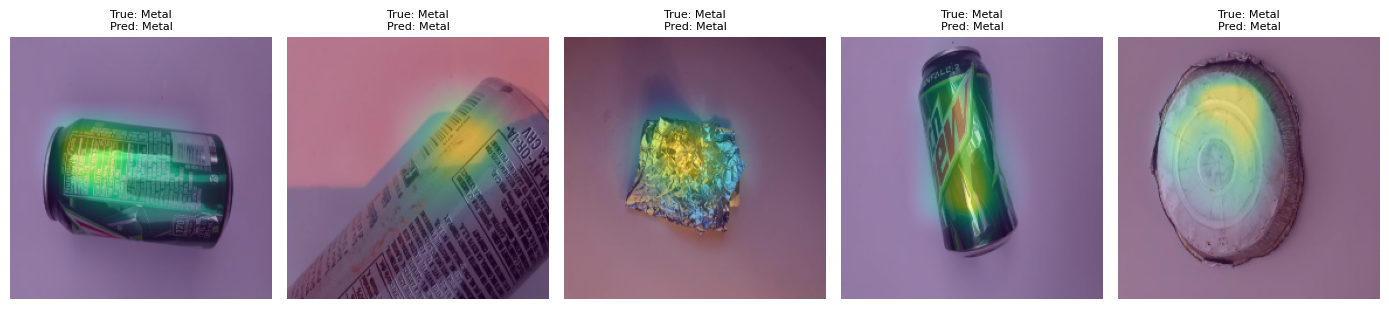

Making model activation map:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s]

 │ Processing images: 5it [00:00, 17.78it/s]


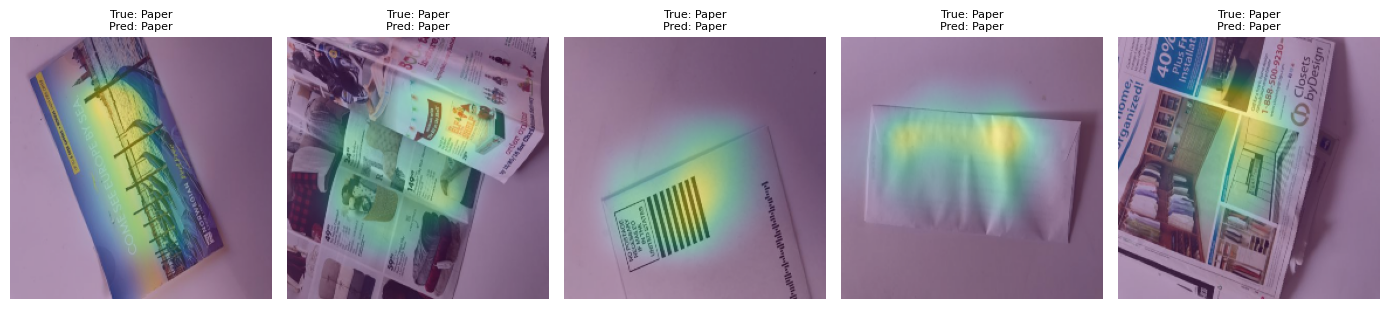

Making model activation map:  67%|██████▋   | 4/6 [00:02<00:00,  2.02it/s]

 │ Processing images: 5it [00:00, 18.52it/s]


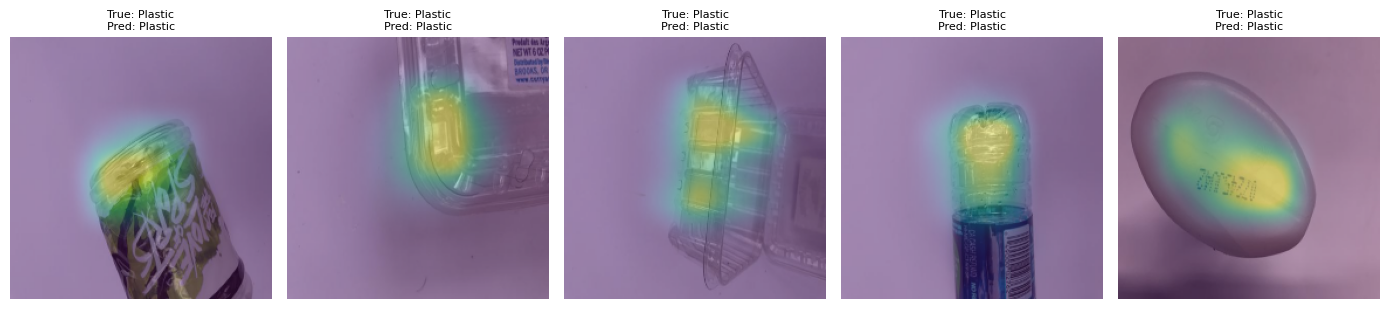

Making model activation map:  83%|████████▎ | 5/6 [00:02<00:00,  2.10it/s]

 │ Processing images: 5it [00:00, 19.09it/s]


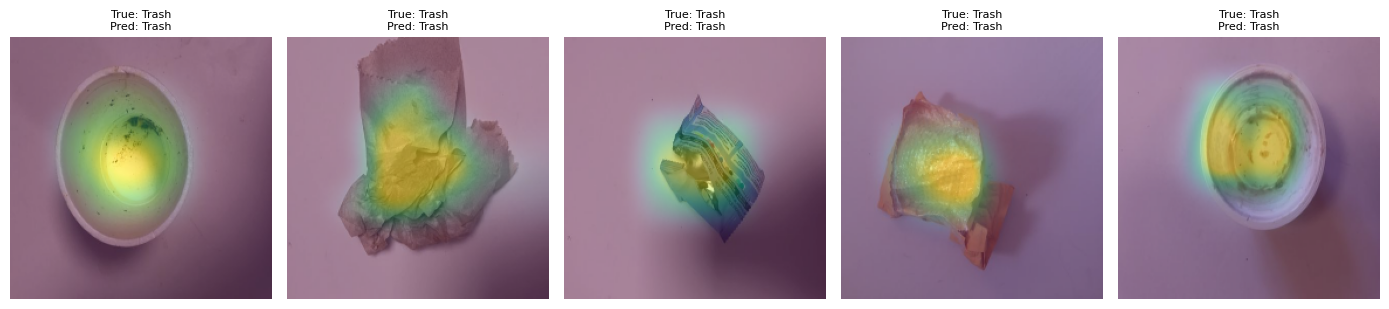

Making model activation map: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

Model analyzation done.


In [9]:
# conf >>>
batch_size = 16
actCam_config = {
    "num_per_lable": 5,  # be divisible by 5
    "cam_method": "LayerCAM",
    "target_layer": "_conv_head",
}
# Prep >>>
cprint("<Fore.YELLOW>Analyzing model Predicting performance...")
model = model.to(device)
Eval_dataloader = DataLoader(
    dataset=TensorDataset_rtDTC(x_test, y_test),
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory_device=device_str,
    pin_memory=True,
    drop_last=False,
)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Eval >>>
Eval_results, all_y_pred, all_y = eval(
    Eval_dataloader,
    model,
    device,
    loss_fn,
    verbose=True,
    return_preds=True,
    TQDM_desc=cprint(
        "<Fore.GREEN>Evaluating<Style.RESET_ALL>", end="", return_string=True
    ),
)

# Print Results >>>
print(tabulate(Eval_results.items(), headers=["Metric", "Value"], tablefmt="github"))

# Standard Confusion Matrix >>>
conf_matrix = confusion_matrix(all_y.argmax(dim=1), all_y_pred.argmax(dim=1))
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Normalized Confusion Matrix >>>
conf_matrix_normalized = confusion_matrix(
    all_y.argmax(dim=1), all_y_pred.argmax(dim=1), normalize="true"
)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

# Activation Maps >>>
# Dict of the CAM methods to use
cam_methods = {
    "GradCAM": GradCAM,
    "GradCAM++": GradCAMpp,
    "SmoothGradCAM++": SmoothGradCAMpp,
    "ScoreCAM": ScoreCAM,
    "SSCAM": SSCAM,
    "ISCAM": ISCAM,
    "XGradCAM": XGradCAM,
    "LayerCAM": LayerCAM,
}
for Label in tqdm(
    labels,
    desc=cprint(
        "<Fore.GREEN>Making model activation map<Style.RESET_ALL>",
        end="",
        return_string=True,
    ),
):
    # Setting the plot fig size + tqdm sep
    print("")
    plt.figure(figsize=(14, (actCam_config["num_per_lable"] // 5) * 4))
    # Getting the samples
    x_samples, y_samples = random_subset(
        x_test,
        y_test,
        num=actCam_config["num_per_lable"],
        label_list=[labels.index(Label)],
    )
    for idx, (x, y) in tqdm(
        enumerate(zip(x_samples, y_samples)),
        desc=cprint(
            " │ <Fore.CYAN>Processing images<Style.RESET_ALL>",
            end="",
            return_string=True,
        ),
    ):
        # Getting the activation map
        cam_method = cam_methods[actCam_config["cam_method"]]
        with cam_method(
            model, actCam_config["target_layer"], input_shape=(x.shape[-1], *img_res)
        ) as cam_extractor:
            # Pred
            model_pred = model(x.to(device).unsqueeze(0).float())
            # Make the activation map
            activation_map = cam_extractor(
                model_pred.squeeze(0).argmax().item(), model_pred
            )
        # Overlay the activation map on the image
        combined_image = overlay_mask(
            to_pil_image(x),
            to_pil_image(activation_map[0].squeeze(0), mode="F"),
            colormap="viridis",
            alpha=0.6,
        )
        plt.subplot(actCam_config["num_per_lable"] // 5, 5, idx + 1)
        plt.imshow(combined_image)
        plt.title(
            f"True: {labels[y.argmax().item()]}\nPred: {labels[model_pred.squeeze().argmax().item()]}",
            fontsize=8,
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# End
cprint("<Fore.GREEN>Model analyzation done.")

1. Plastic - confidence: 88.3731%
2. Trash - confidence: 3.5970%
3. Metal - confidence: 2.9027%
4. Cardboard - confidence: 2.5112%
5. Glass - confidence: 1.3529%
6. Paper - confidence: 1.2632%


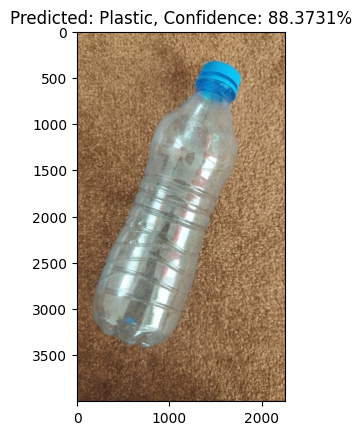

In [23]:
# image file name
image_name = "Exi.jpg"

# Define the transformation
transform = v2_transforms.Compose(
    [
        v2_transforms.ToTensor(),
    ]
)

# Load the image
image = Image.open(image_name).resize((224, 224))

# Apply the transformation to the image
image = transform(image)

# Add an extra dimension
image = image.unsqueeze(0)  # type: ignore

# Move the image and model to device
image = image.to(device)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
output = model(image)

# Get the predicted class
_, predicted = torch.max(output, 1)

# Calculate the confidence of the prediction
confidence = nn.functional.softmax(output, dim=1)[0]
for i, confid in enumerate(sorted(confidence.tolist(), reverse=True), start=1):
    print(
        f"{i}. {labels[confidence.tolist().index(confid)]} - confidence: {confid:.4%}"
    )

# Get the predicted label
predicted_label = labels[predicted]

# Show the image with the predicted label and the confidence
plt.imshow(Image.open(image_name))
plt.title(
    f"Predicted: {predicted_label}, Confidence: {confidence[predicted].item():.4%}"
)
plt.show()